In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, shapiro
from scipy.optimize import newton
from statsmodels.graphics.gofplots import qqplot

import warnings
warnings.filterwarnings('ignore')

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
# Variáveis para o gráfico

plot_params = {'legend.fontsize': 30,
               'figure.figsize': (20, 10),
               'axes.labelsize':  30,
               'axes.titlesize':  30,
               'xtick.labelsize': 25,
               'ytick.labelsize': 25,
               'figure.dpi': 300}

plt.style.use('ggplot')

plt.rcParams.update(plot_params)

color_dark_blue = [1/255, 62/255, 125/255]
color_light_blue = [6/255, 143/255, 203/255]
purple = [102/255, 51/255, 153/255]

color = [color_dark_blue, color_light_blue, purple]

# Modelo de Heston

No modelo de Heston, o ativo subjacente $S$, segue a seguinte dinâmica sob a medida $\mathbb{Q}$:
$$\left\{\begin{array}{lll} 
dS_t = r S_t dt + \sqrt{\nu_t} S_t dW^S_t,&\\
d\nu_t = \kappa (\overline{\nu} - \nu_t)dt + \xi \sqrt{\nu_t} dW^\nu_t,&
\end{array}\right. $$
onde $W^S$ e $W^\nu$ são movimentos Brownianos sob $\mathbb{Q}$ com correlação $\rho \in [-1,1]$. Todos os parâmetros do processo de volatilidade são positivos: $\kappa$ é a velocidade de reversão à media da volatilidade, $\overline{\nu} > 0$ é a média de longo prazo da volatilidade, $\xi > 0$ é a vol-vol e $r$ é a taxa de juros livre de risco.

Sob esse modelo, o preço de um derivativo com maturidade $T$ e payoff $g(S_T)$ é dado pela integral:
\begin{align}
P(t,S,v) = \frac{e^{-r\tau}}{\pi} \int_0^{+\infty} Real \left(e^{-i z x} \hat{G}(\tau,z,v) \hat{g}(z) \right)dz_r , \label{eq:fourier_price}
\end{align}
onde
\begin{align}
&z = z_r + iz_i, \ z_i fixo, \ \ \tau = T-t,\ \ x = r\tau + \log S, \\
&\hat{g}(z) = \int_{\mathbb{R}} e^{iz x} g(e^{x}) dx, \\
&\widehat{G}(\tau,z,v) = e^{A(\tau,z) + vB(\tau,z)}, \\
&A(\tau,z) = \frac{\kappa \overline{\nu} }{\xi^2} \left( (\kappa + i\rho \xi z - d(z)) \tau - 2 \log\left( \frac{e^{-d(z)\tau}/h(z) - 1}{1/h(z) - 1} \right) \right), \\
&B(\tau,z) = \frac{\kappa + i\rho \xi z + d(z)}{\xi^2}\left( \frac{1 - e^{d(z)\tau}}{1 - h(z)e^{d(z)\tau}} \right), \\
&h(z) = \frac{\kappa + i\rho \xi z + d(z)}{\kappa + i\rho \xi z - d(z)},\\
&d(z) = \sqrt{\xi^2(z^2 - iz) + (\kappa + i\rho \xi z)^2}.
\end{align}

A seguinte lista mostra diversos payoff $g$ e suas transformações $\hat{g}$:

$\bullet$ Call: $g(S) = (S-K)^+$, $\hat{g}(z) = -\tfrac{K^{iz+1}}{z^2 - iz}$, com $z_i > 1$

$\bullet$ Put: $g(S) = (K-S)^+$, $\hat{g}(z) = -\tfrac{K^{iz+1}}{z^2 - iz}$, com $z_i < 0$

$\bullet$ Covered Call: $g(S) = \min\{S,K\}$, $\hat{g}(z) = \tfrac{K^{iz+1}}{z^2 - iz}$, com $0 < z_i < 1$

$\bullet$ Digital Call: $g(S) = 1_{\{S \geq K\}}$, $\hat{g}(z) = -\frac{K^{iz}}{iz}$, com $z_i > 0$

$\bullet$ Digital Put: $g(S) = 1_{\{S \leq K\}}$, $\hat{g}(z) = \frac{K^{iz}}{iz}$, com $z_i < 0$

$\bullet$ Asset-or-Nothing Call: $g(S) = S \ 1_{\{S \geq K\}}$, $\hat{g}(z) = -\frac{K^{iz+1}}{iz+1}$, com $z_i > 1$

$\bullet$ Asset-or-Nothing Put: $g(S) = S 1_{\{S \leq K\}}$, $\hat{g}(z) = \frac{K^{iz+1}}{iz+1}$, com $z_i < 0$


In [5]:
#algumas funções de simulação e do modelo de Black-Scholes
def SimulateBrownian(N, M, dt):
    dW = np.sqrt(dt) * np.random.normal(size=(N,M))
    brownian_paths = np.zeros((N+1,M))
    brownian_paths[1:,:] = np.cumsum(dW, axis=0)
    
    return brownian_paths

def SimulateGBM(S0, sigma, drift, N, M, time, W=None):

    dt = time[1] - time[0]
    time_matrix = np.repeat(time, M).reshape(N+1,M) # vetor de tempos repetidos
    
    if W is None:
        W = SimulateBrownian(N, M, dt)

    paths = S0 * np.exp((drift - sigma**2/2) * time_matrix + sigma * W)

    return paths

def BlackScholesFormula(S, T, K, sigma, r):
    
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call_price = S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    
    return call_price

def BlackScholesVega(S, T, K, sigma, r):
    
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma * np.sqrt(T))
    
    call_vega = S * norm.pdf(d1) * np.sqrt(T)
    
    return call_vega

def ImpliedVolatility(S, T, K, r, call_price, sigma0=0.2):
    
    func = lambda sigma: BlackScholesFormula(S, T, K, sigma, r) - call_price
    fprime = lambda sigma: BlackScholesVega(S, T, K, sigma, r)
    
    res = newton(func, x0=sigma0, fprime=fprime)
    
    return res

In [6]:
def HestonFormula(S0, T, K, r, params):
    '''
    Função que calcula o preço de uma call (T,K) no modelo de Heston
    S0 (float > 0) - valor inicial do ativo subjacente
    T (float > 0) - maturidade (em anos)
    K (array > 0) - strikes
    r (float) - taxa de juros livre de risco
    param(dict) - dicionário com as seguintes keys: 'xi', 'kappa', 'm', 'V0' e 'rho':
        xi (float > 0) - vol-vol
        kappa (float > 0) - mean reversion rate
        m (float > 0) - long run mean
        V0 (float > 0) - vol inicial
        rho (float em [-1,1]) - correlação vol-ativo
    '''
    points, weights = np.polynomial.laguerre.laggauss(deg=30)

    z_i = 2
    z = points + 1j * z_i

    xi = params['xi']
    kappa = params['kappa']
    rho = params['rho']
    m = params['m']
    V0 = params['V0']

    d = np.sqrt(xi**2 * (z**2 - 1j*z) + (kappa + 1j*rho*xi*z)**2)
    g = (kappa + 1j * rho * xi * z + d)/(kappa + 1j * rho * xi * z - d)

    exp_aux = np.exp(d * T)

    D = (kappa + 1j * rho * xi * z + d)/xi**2 * (1 - exp_aux)/(1 - g * exp_aux)

    C = kappa * m / xi**2 * ((kappa + 1j * rho * xi * z - d)*T - 2 * np.log((1/(g*exp_aux) - 1)/(1/g - 1)))

    G = np.exp(C + V0 * D)

    x = r*T + np.log(S0)

    call_prices = np.zeros(len(K))

    for i in range(len(K)):

        payoff = -K[i]**(1j*z + 1) / (z**2 - 1j*z)

        integrand = np.real(np.exp(-1j * z * x) * G * payoff)

        call_prices[i] = np.exp(-r*T)/np.pi * np.sum(weights * np.exp(points) * integrand)

    return call_prices

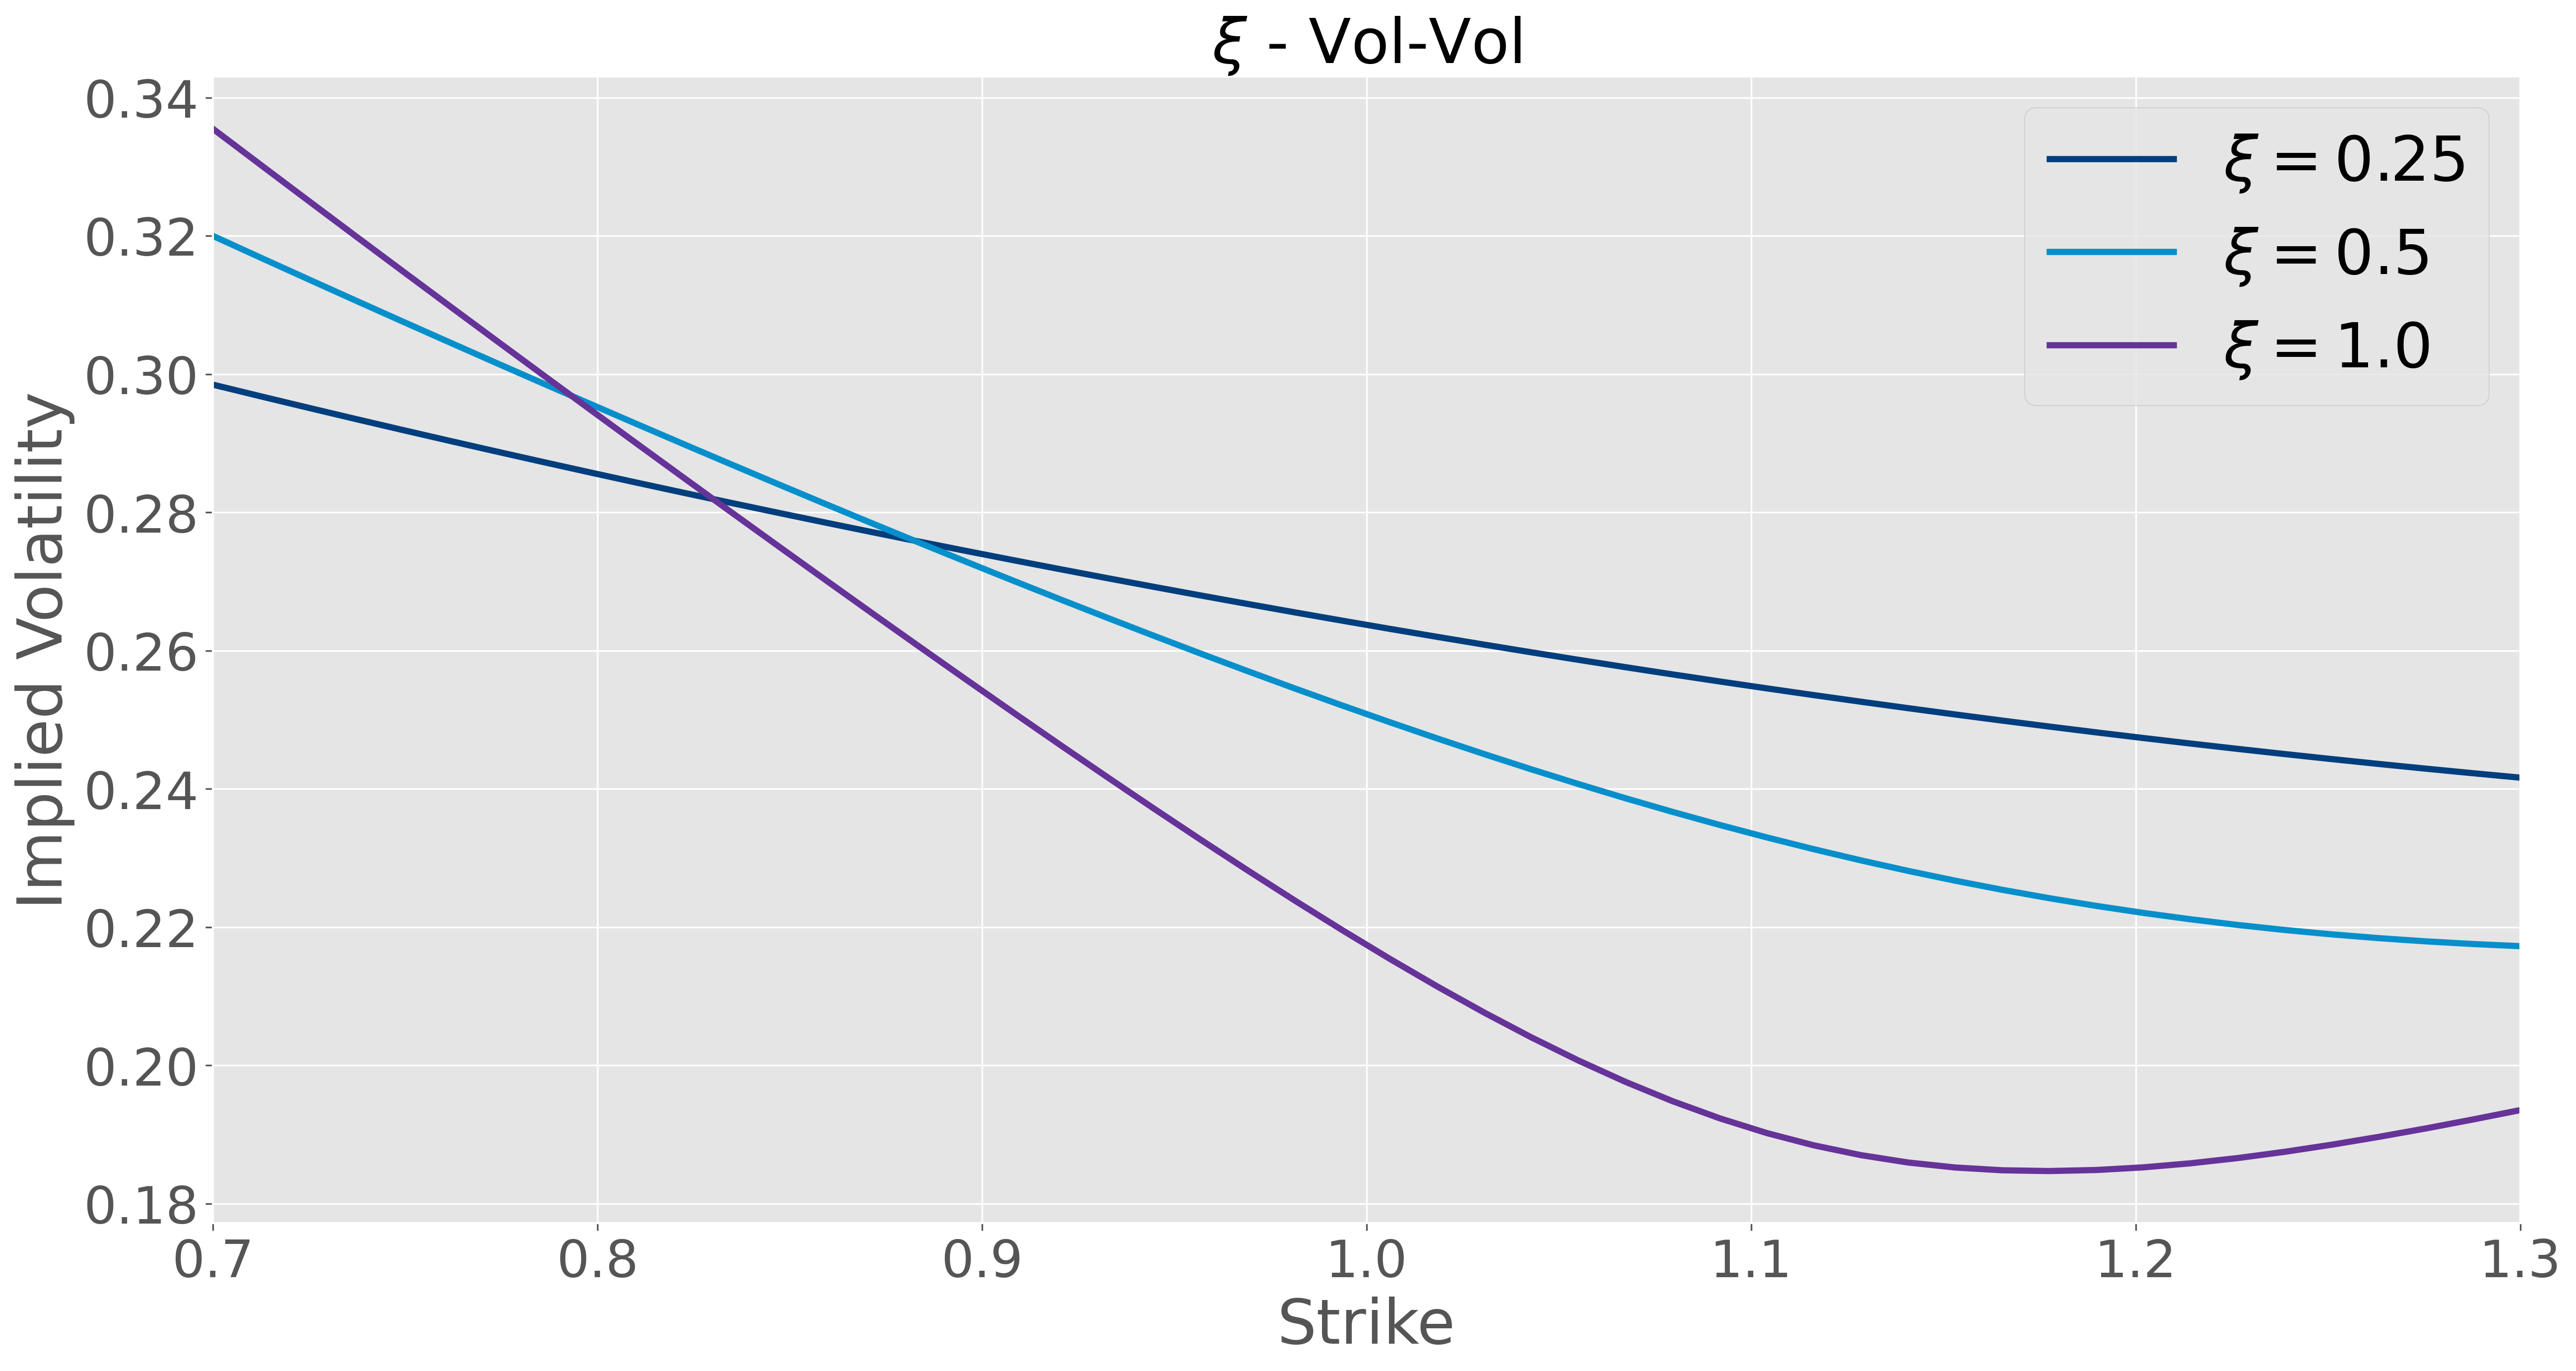

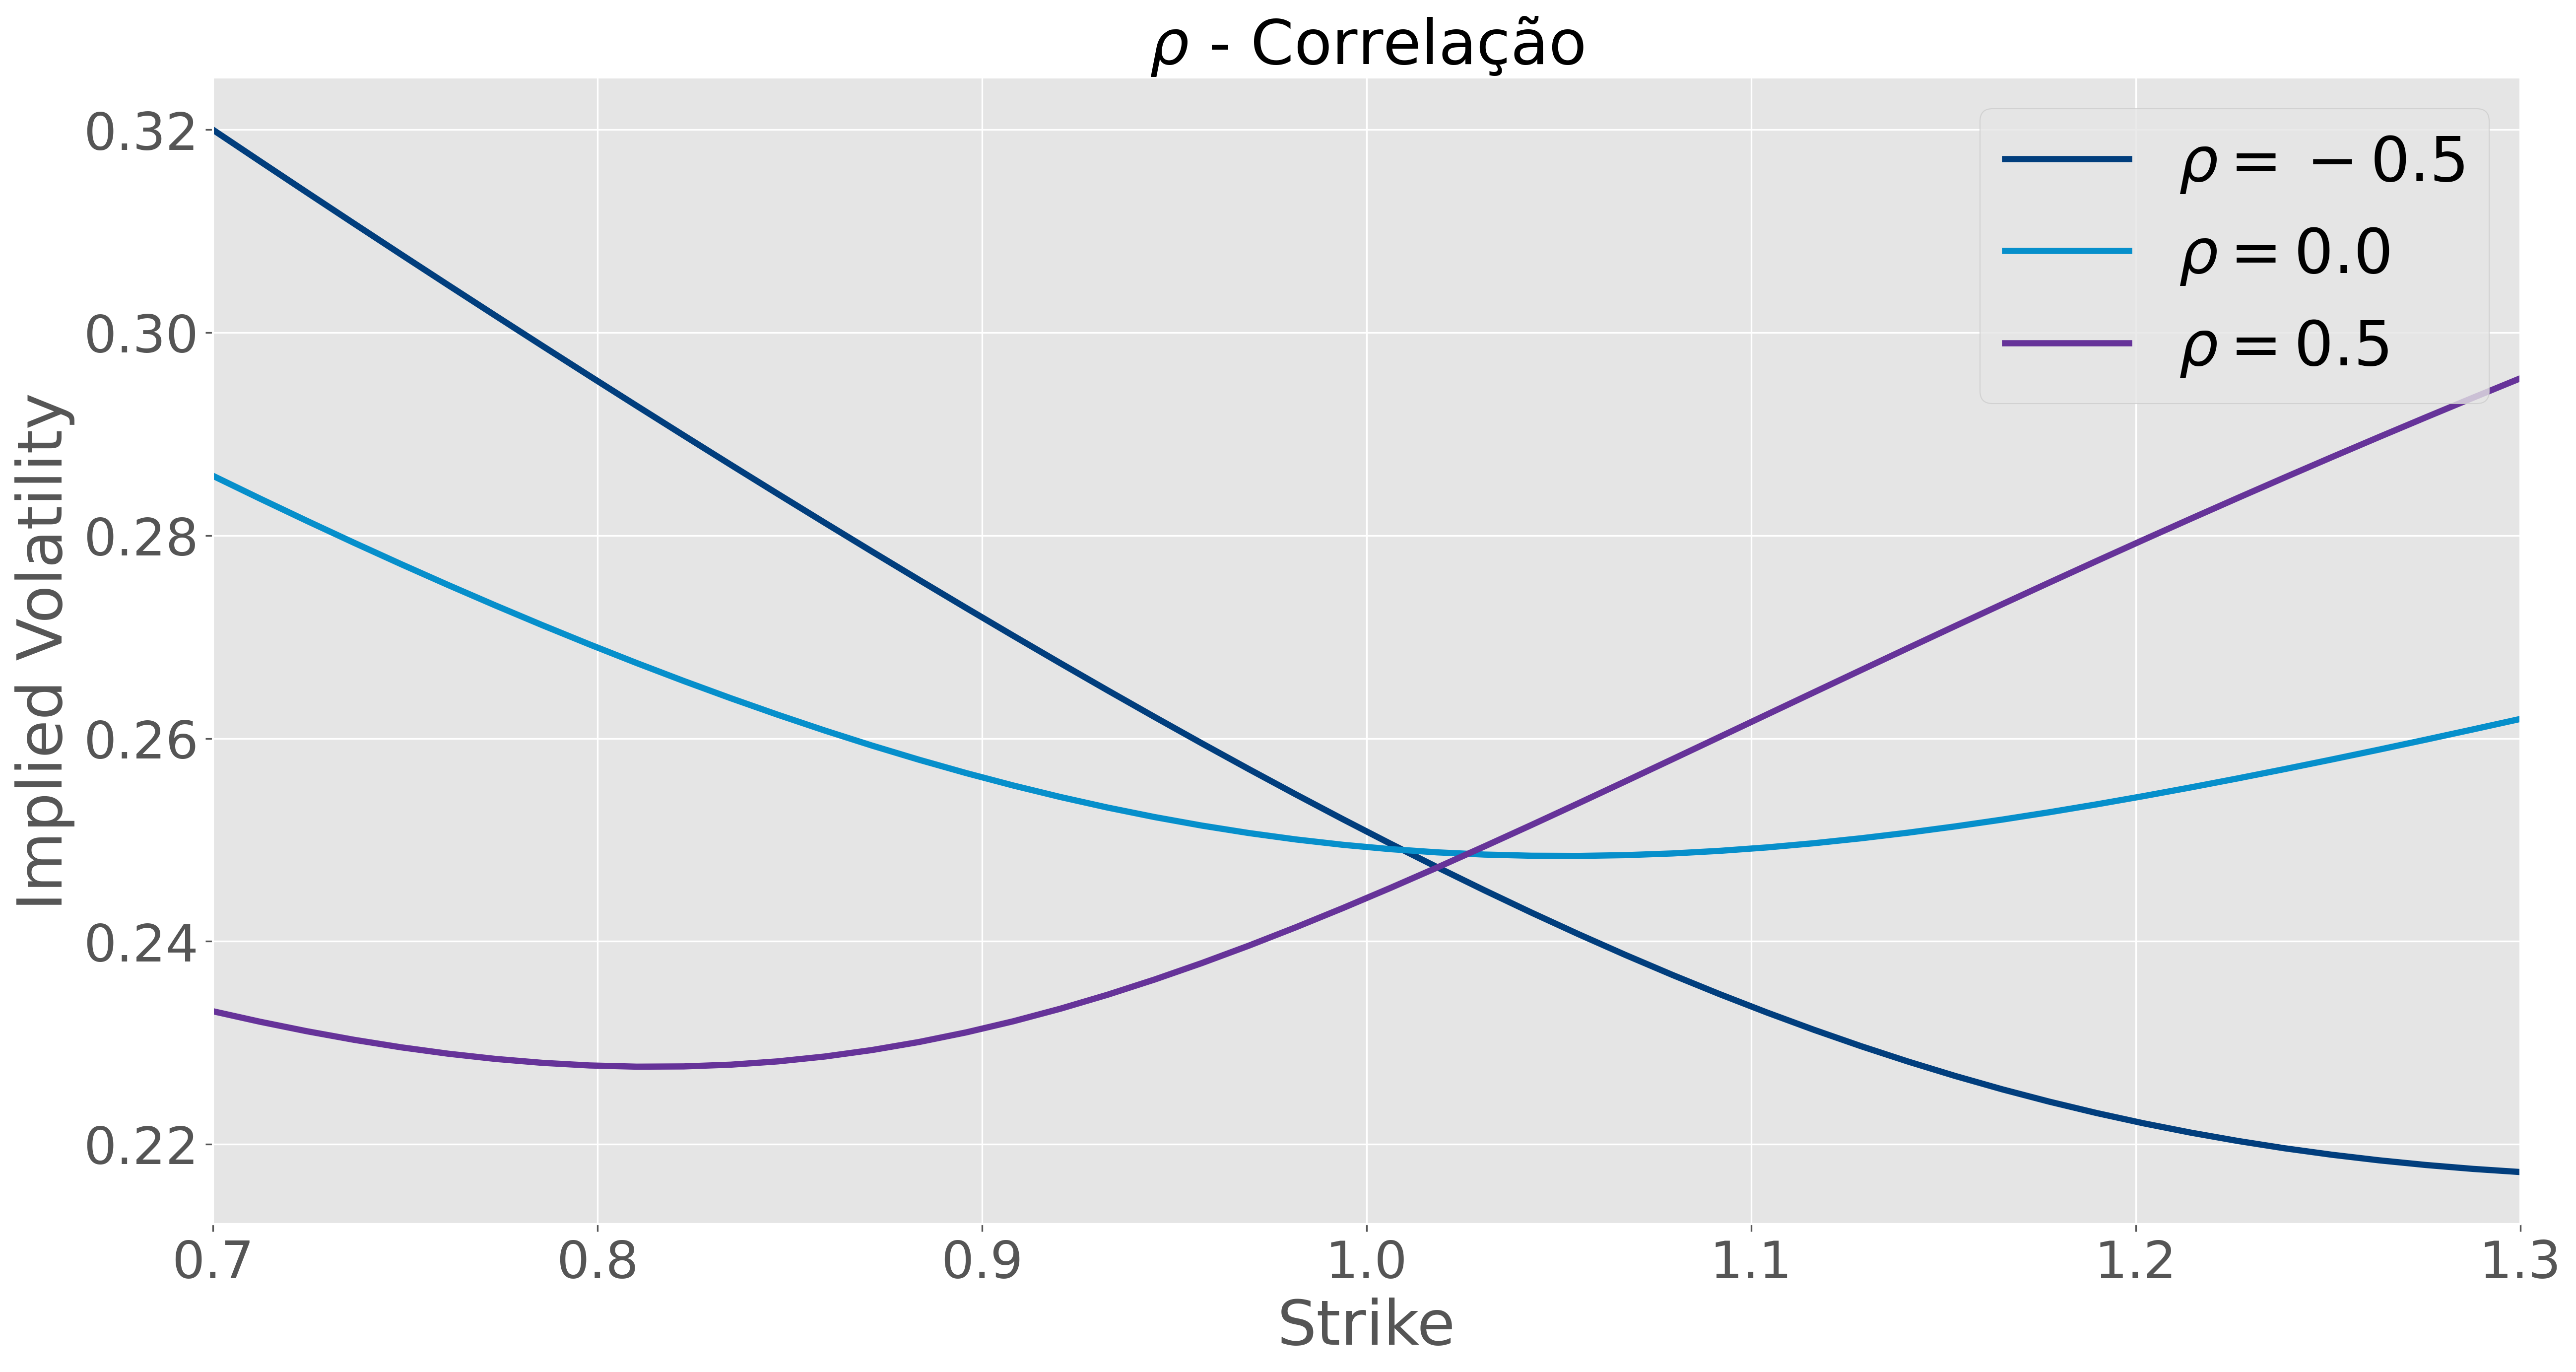

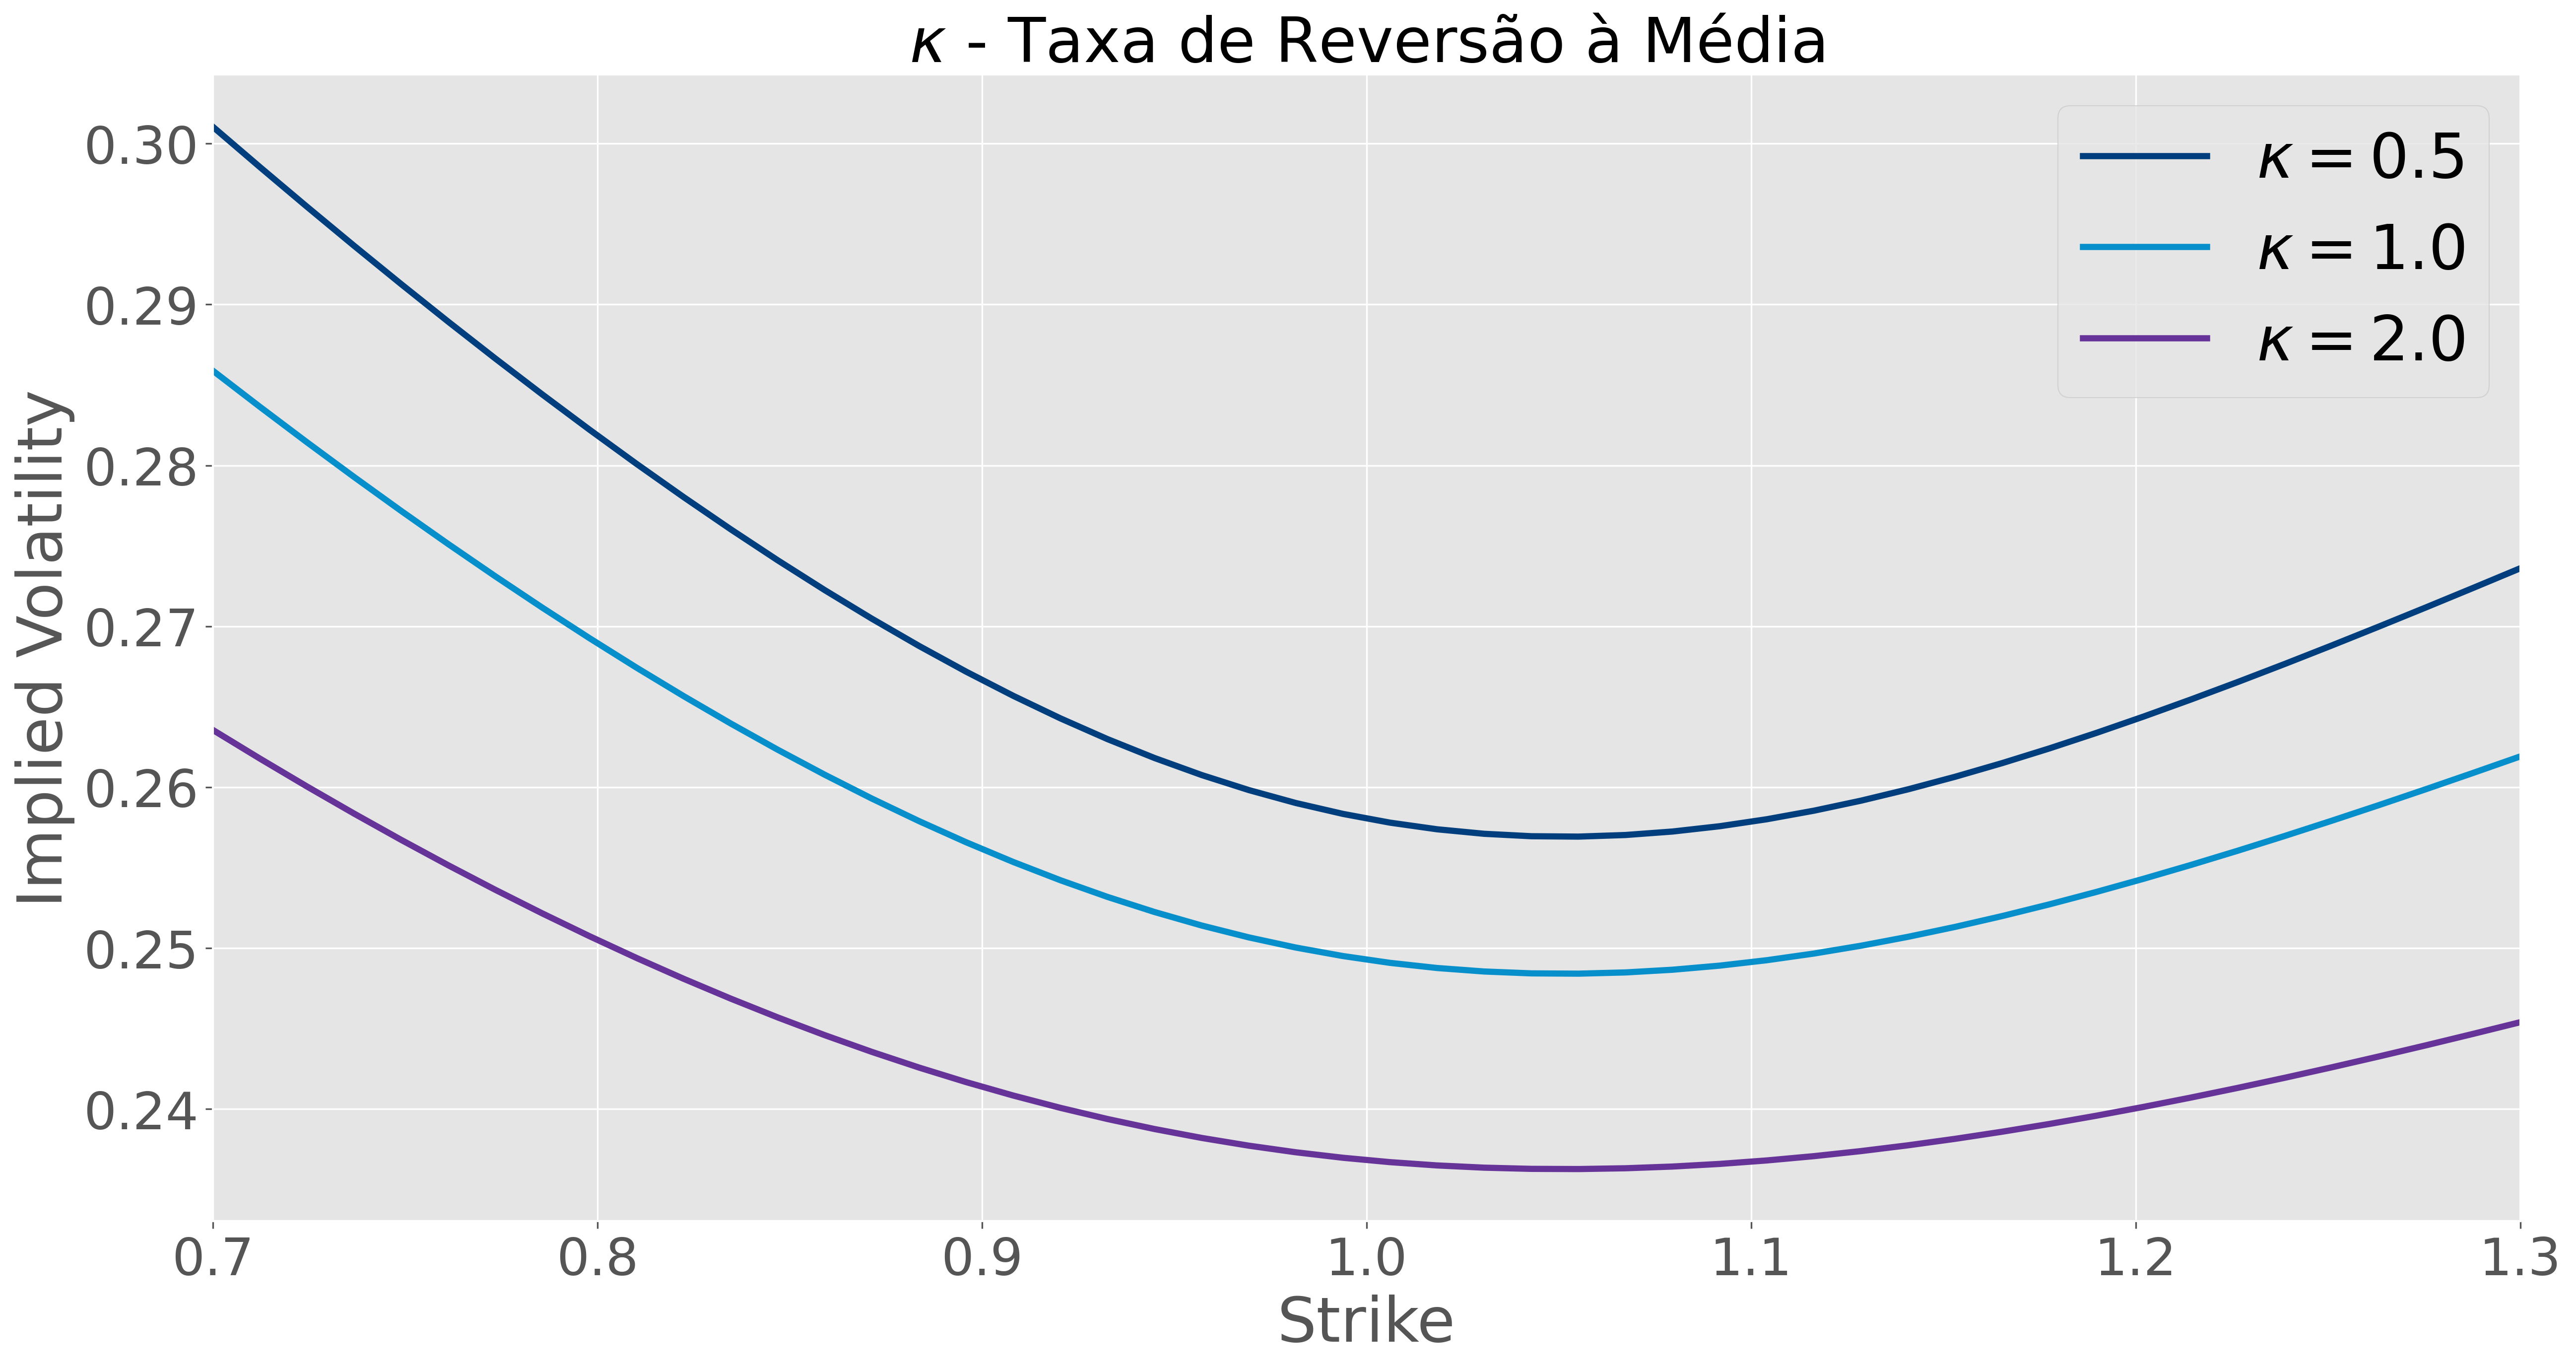

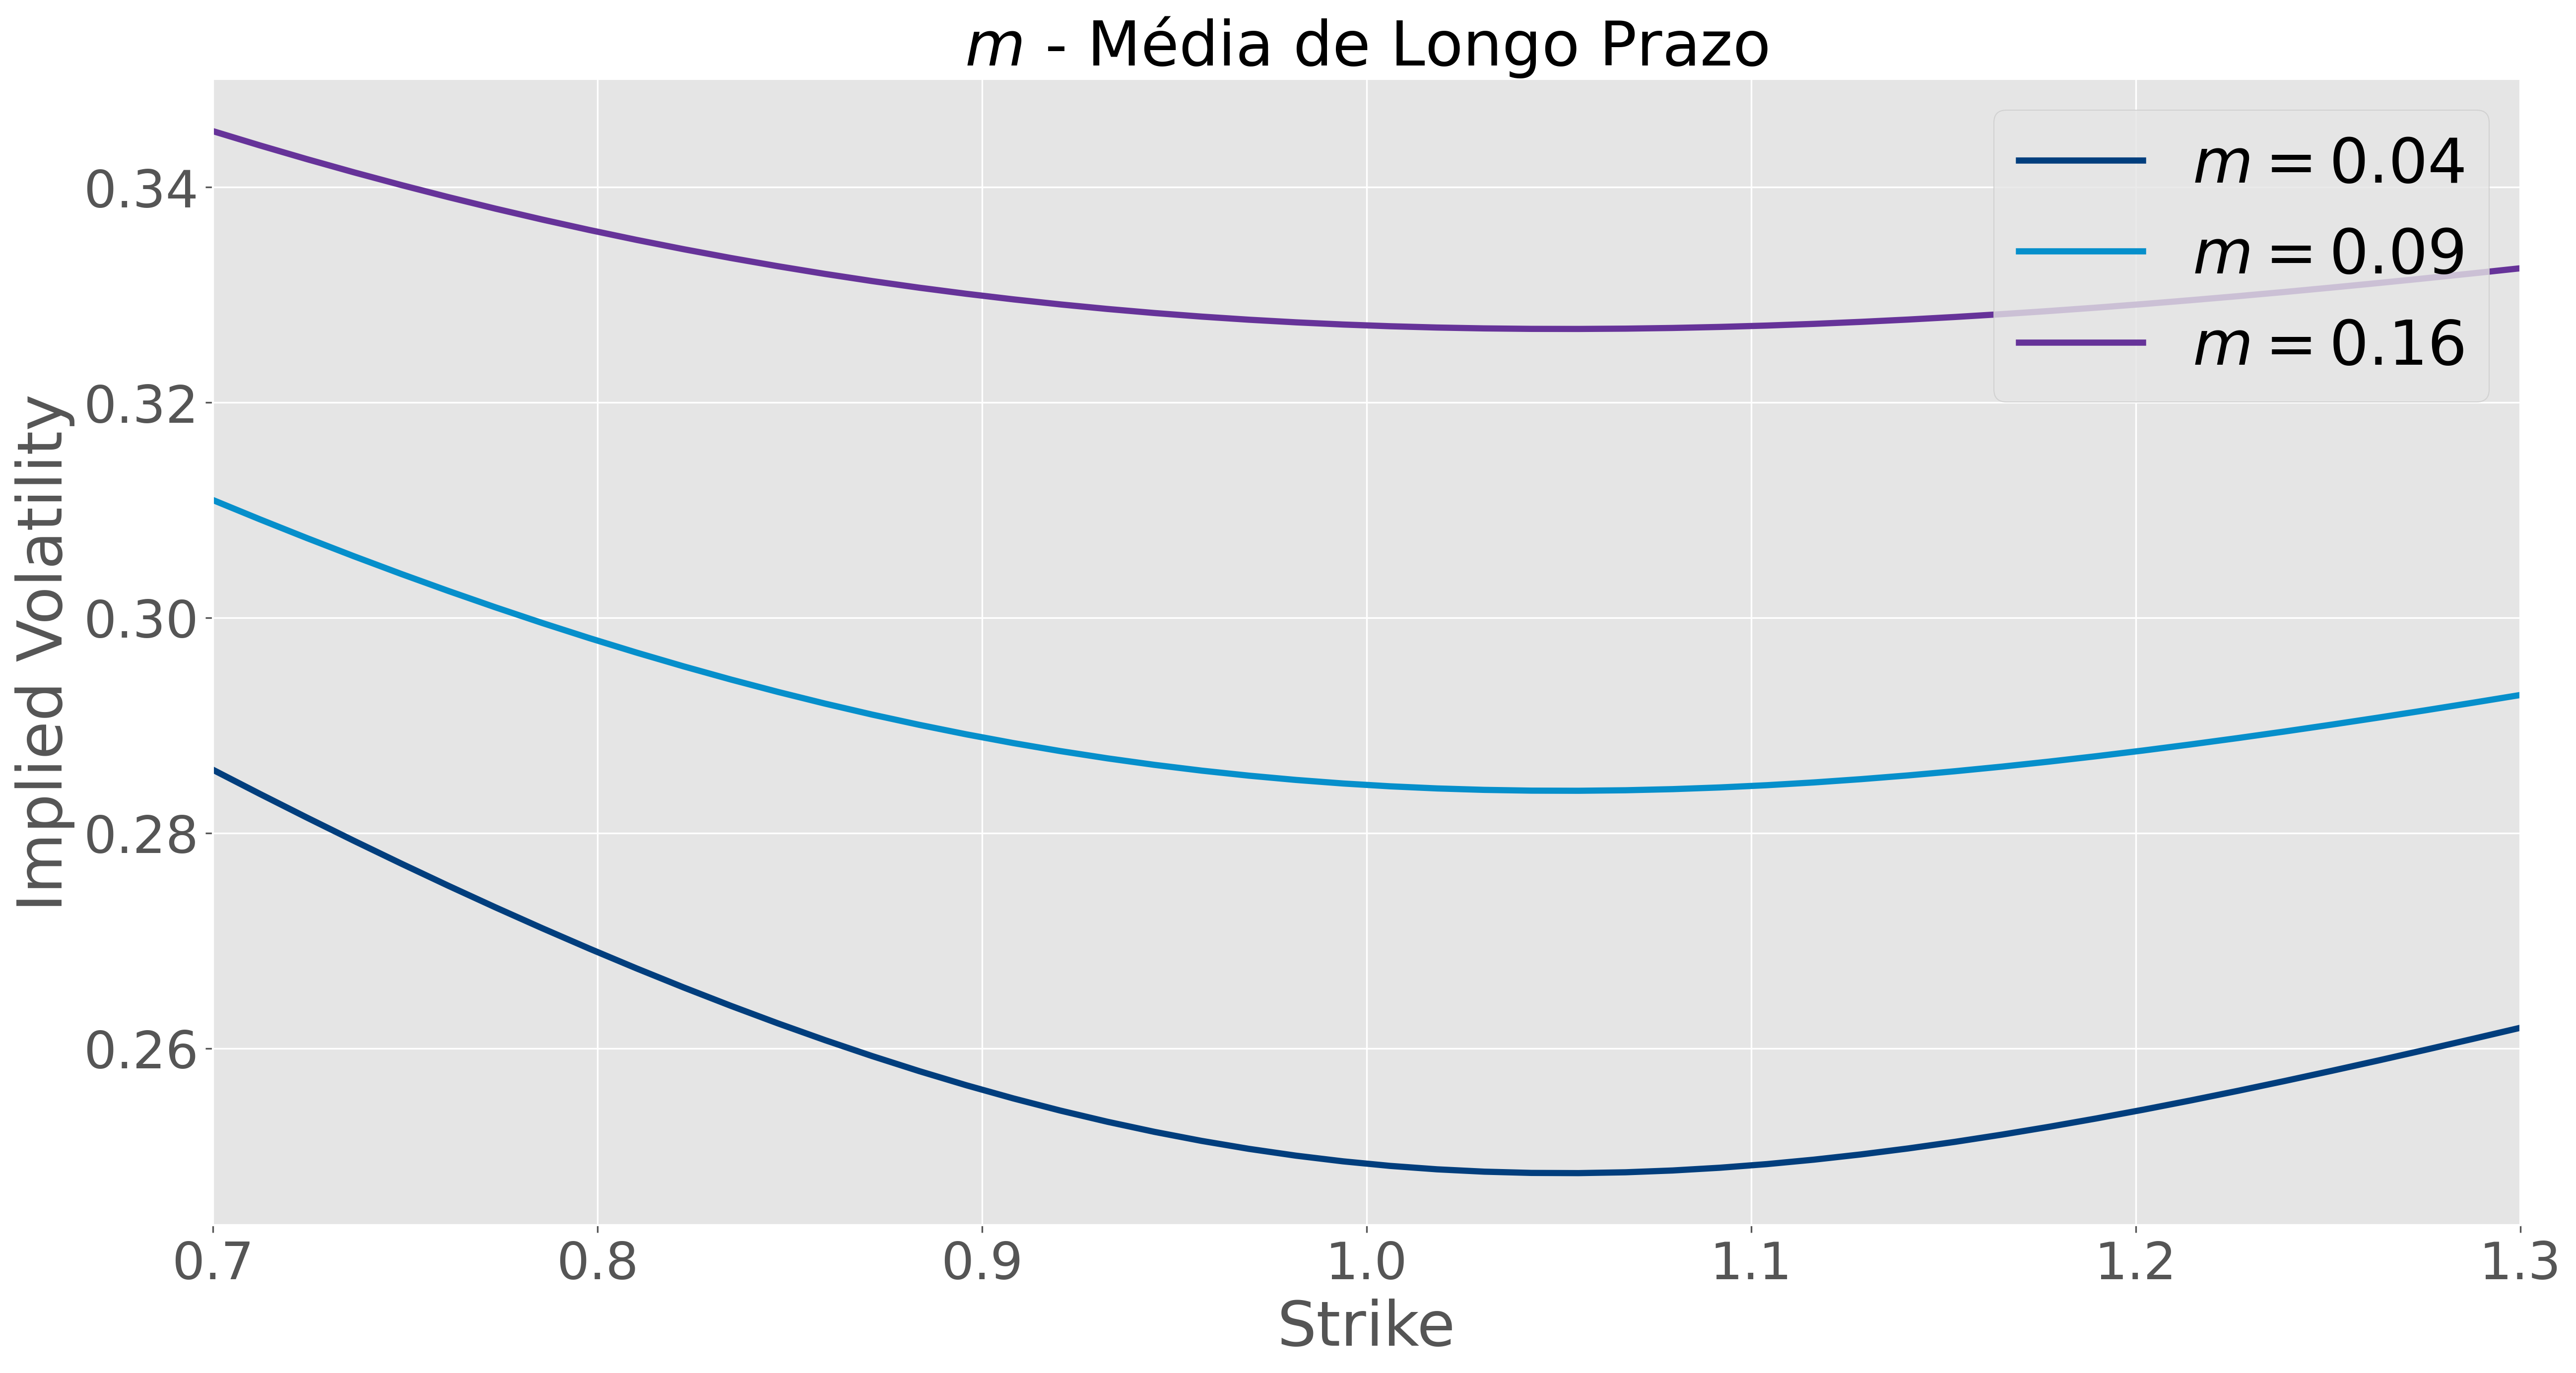

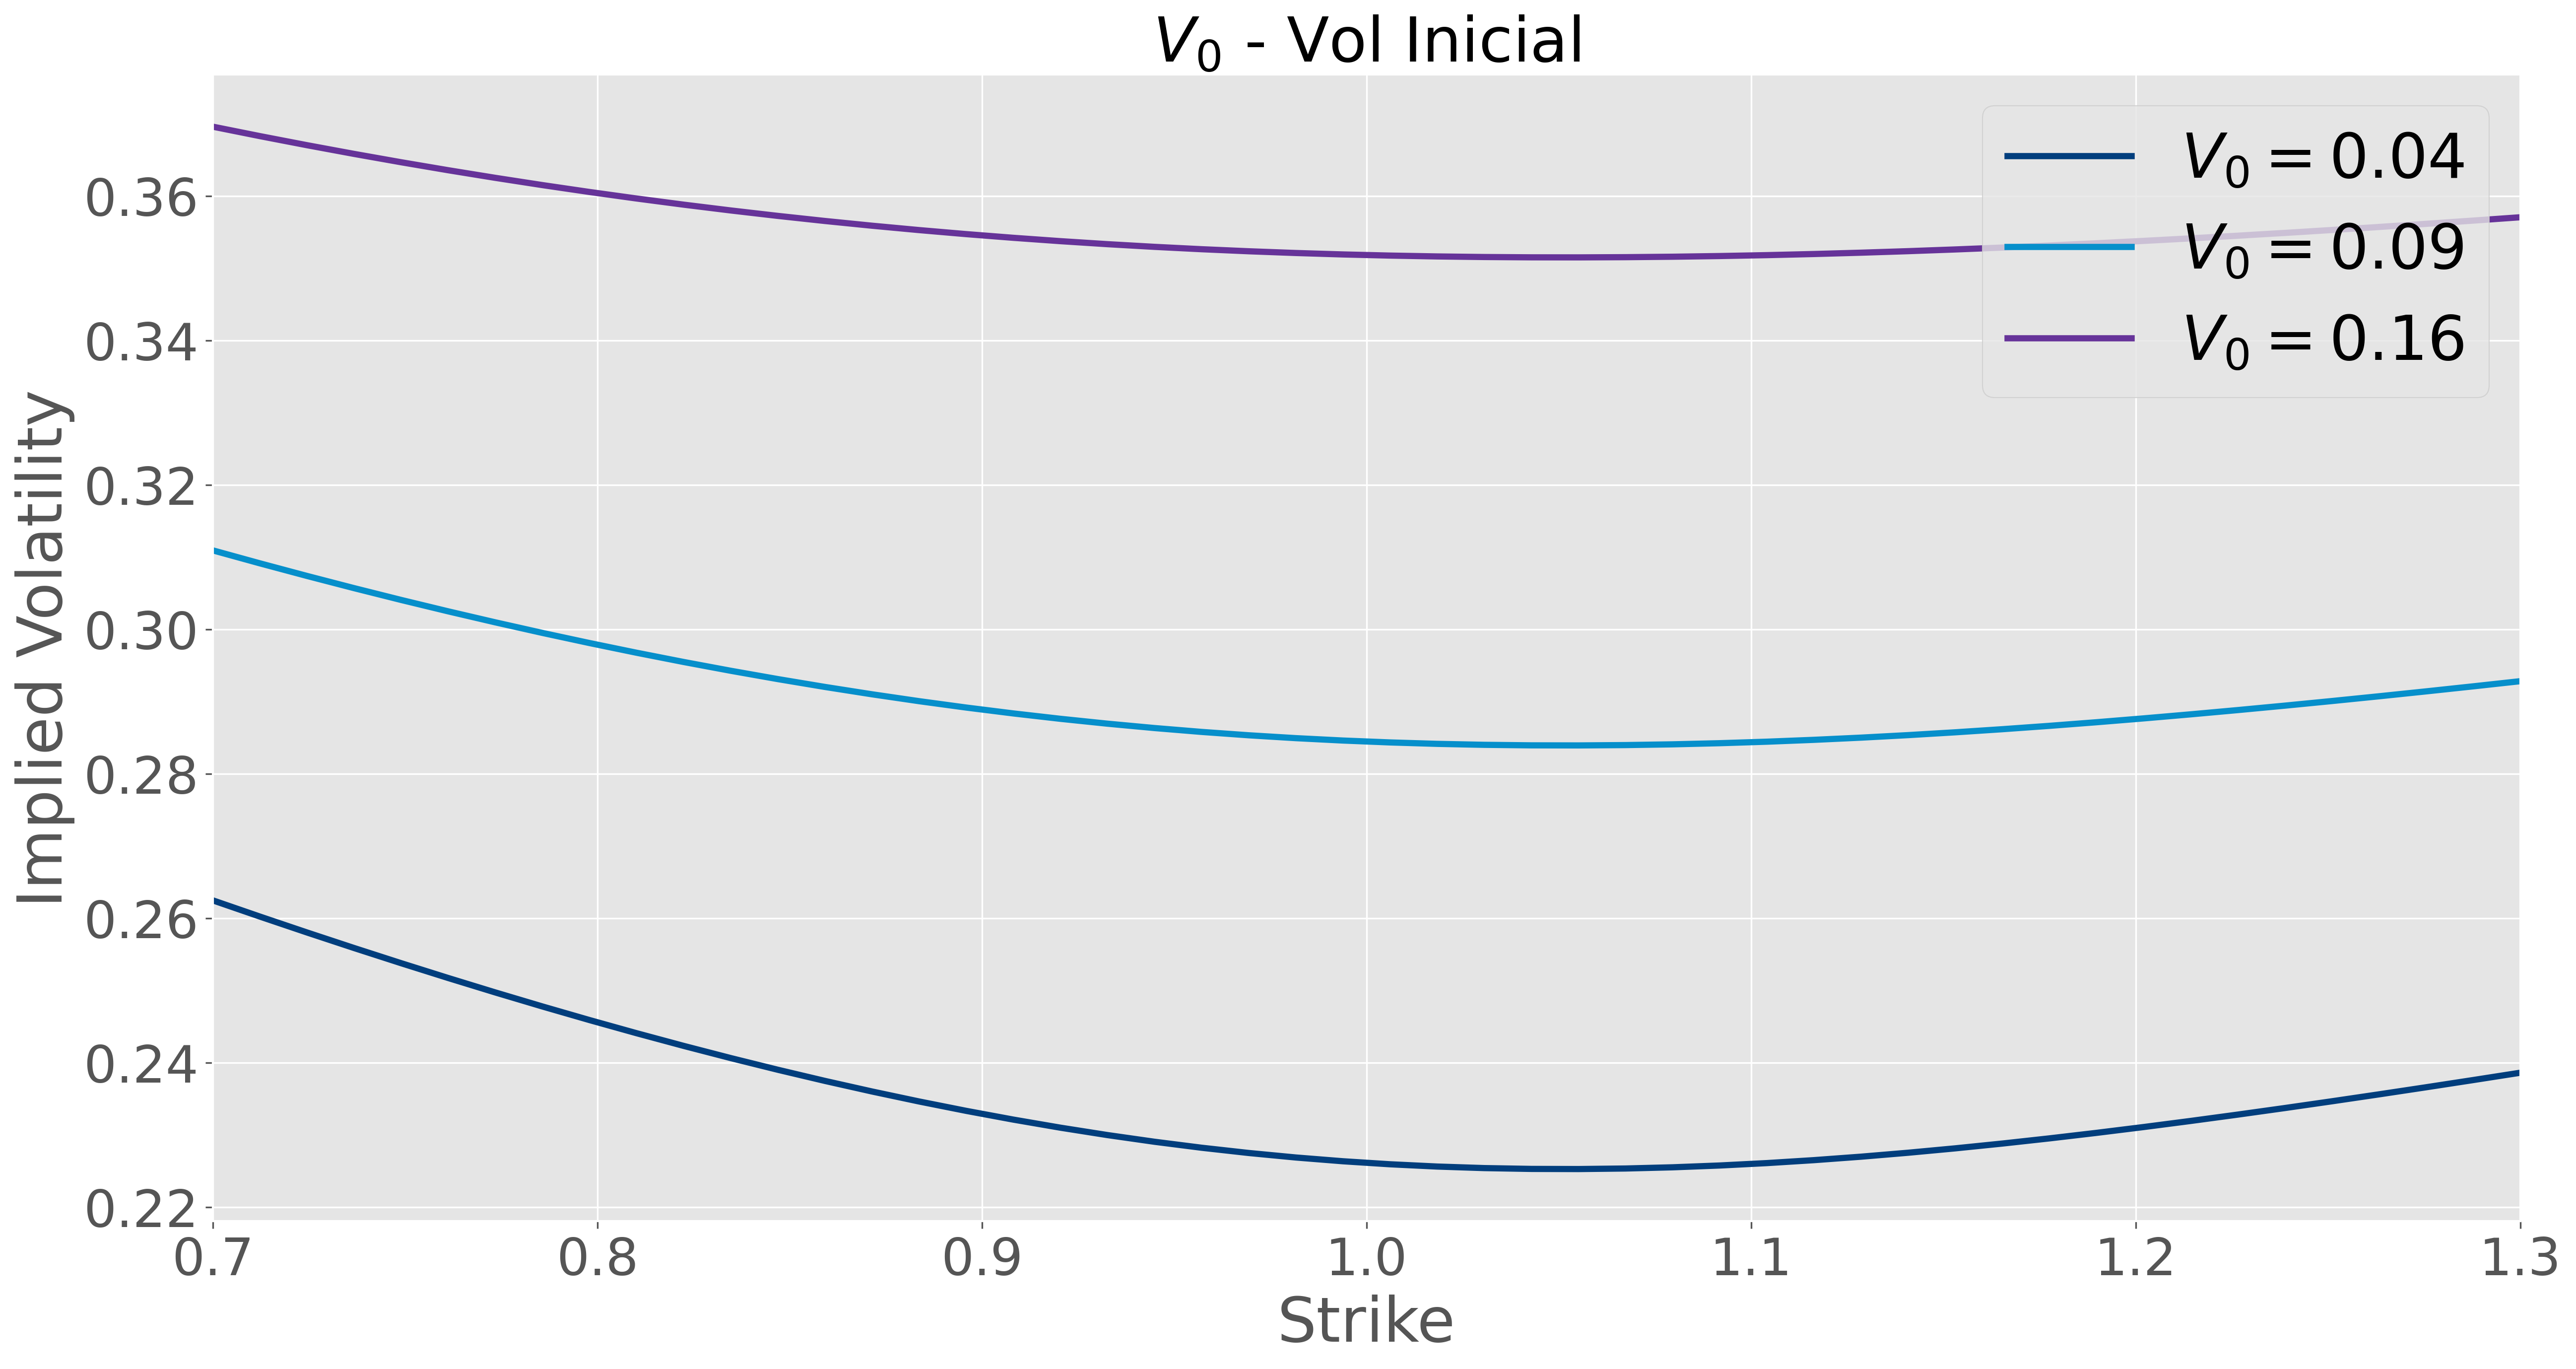

In [7]:
T = 1 #maturidade
S0 = 1 #valor inicial do ativo subjacente
K = S0 * np.linspace(0.7, 1.3, 50) #strikes
r = 0.05 # taxa de juros livre de risco
params =  {'xi': 0.5, 'rho':-0.5, 'V0': 0.09, 'm': 0.04, 'kappa': 1} #baseline dos parâmetros

plt.rcParams.update(plot_params)

param_vary = {'xi': [0.25, 0.5, 1.0], 'rho':[-0.5, 0.0, 0.5], 'kappa':[0.5, 1.0, 2.0], 
    'm': [0.04, 0.09, 0.16], 'V0': [0.04, 0.09, 0.16]} #variação dos parâmetros

tex_param = {'xi': '\\xi', 'rho':'\\rho', 'kappa':'\\kappa', 
             'm': 'm', 'V0': 'V_0'} #latex do parâmetros para plot
text_param = {'xi': 'Vol-Vol', 'rho':'Correlação', 'kappa':'Taxa de Reversão à Média', 
             'm': 'Média de Longo Prazo', 'V0': 'Vol Inicial'} #latex do parâmetros para plot

for param in ['xi', 'rho', 'kappa', 'm', 'V0']:

    implied_vol_vary = []

    for p in param_vary[param]:

        params[param] = p

        call_prices = HestonFormula(S0, T, K, r, params)
        
        implied_vols = np.zeros(len(K))

        for i in range(len(K)):
            implied_vols[i] = ImpliedVolatility(S0, T, K[i], r, call_prices[i])

        implied_vol_vary.append(implied_vols)

    params[param] = param_vary[param][1] #volta com o valor baseline
    
    plt.figure()    
    for i in [0,1,2]:
        plt.plot(K, implied_vol_vary[i], linewidth=3 ,label=r'$' + tex_param[param]  + ' = ' + str(param_vary[param][i]) + '$', color=color[i])
    plt.xlabel('Strike')
    plt.ylabel('Implied Volatility')
    plt.xlim(K[0], K[-1])
    plt.legend(loc='upper right')
    plt.title(r'$' + tex_param[param] + '$ - ' + text_param[param])

# Simulando o Modelo de Heston

Simular o processo $\nu$ do modelo de Heston pode ser complicado por causa do termo $\sqrt{\nu_t}$ em sua dinâmica e da possibilidade de se simular $\nu_t < 0$. Uma simples solução, mas que adiciona um certo viés na simulação, é simular usando o processo em tempo discreto abaixo:
$$v_{t_{i+1}} = \max\left\{ v_{t_i} + \kappa (\bar{\nu} - v_{t_i}) \Delta t + \xi \sqrt{v_{t_i}} (W_{t_{i+1}}^\sigma - W_{t_i}^\sigma), \ \ 0 \right\},$$
ou seja, colocamos o valor zero caso o valor de $v_{t_{i+1}}$ fosse ser negativo. Nesse caso, temos
$$v_{t_{i+2}} = \kappa \bar{\nu} \Delta t > 0.$$

Outro ingrediente necessário para simular o processo $S$ no modelo de Heston é a simulação de um processo Browniano correlacionado. Mas isso segue facilmente da decomposição
$$W^S_t = \rho W^\sigma_t + \sqrt{1 - \rho^2} W^{\sigma^\perp}_t,$$
onde $W^{\sigma^\perp}$ é um movimento Browniano independente de $W^\sigma$. Logo, pode-se usar o método de Euler--Maruyama para simular $S$ na medida neutra ao risco $\mathbb{Q}$:
$$X_{t_{i+1}} = X_{t_i} + r X_{t_i} \Delta t + \sqrt{v_{t_i}} X_{t_i} (W_{t_{i+1}}^S - W_{t_i}^S),$$
onde estamos denotando o processo em tempo discreto por $X$.

In [8]:
def SimulateHeston(S0, r, params, dt, N, M):
    '''
    Função que simula o preço do ativo subjacente e sua volatilidade no modelo de Heston
    S0 (float > 0) - valor inicial do ativo subjacente
    r (float) - taxa de juros livre de risco
    param(dict) - dicionário com as seguintes keys: 'xi', 'kappa', 'm', 'V0' e 'rho':
        xi (float > 0) - vol-vol
        kappa (float > 0) - mean reversion rate
        m (float > 0) - long run mean
        V0 (float > 0) - vol inicial
        rho (float em [-1,1]) - correlação vol-ativo
    dt (float > 0) - incremento do tempo
    N (int) - discretização do tempo
    M (int) - número de simulações para estimação por Monte Carlo
    '''
    
    xi = params['xi']
    kappa = params['kappa']
    rho = params['rho']
    m = params['m']
    V0 = params['V0']

    dW = np.sqrt(dt) * np.random.normal(size=(N,M))
    dW_indep = np.sqrt(dt) * np.random.normal(size=(N,M)) 
    dW_corr = rho * dW + np.sqrt(1 - rho**2) * dW_indep

    S = np.zeros((N+1, M))
    V = np.zeros((N+1, M))

    S[0,:] = S0
    V[0,:] = V0

    for i in range(N):
        S[i+1, :] = S[i, :] + r * S[i, :] * dt + np.sqrt(V[i,:]) * S[i, :] * dW_corr[i,:]    
        V[i+1, :] = V[i, :] + kappa * (m - V[i, :]) * dt + xi * np.sqrt(V[i, :]) * dW_corr[i,:]
        V[i+1, :] = np.maximum(V[i+1, :], 0.0) 

    return S, V

Text(0, 0.5, 'Preço do ativo')

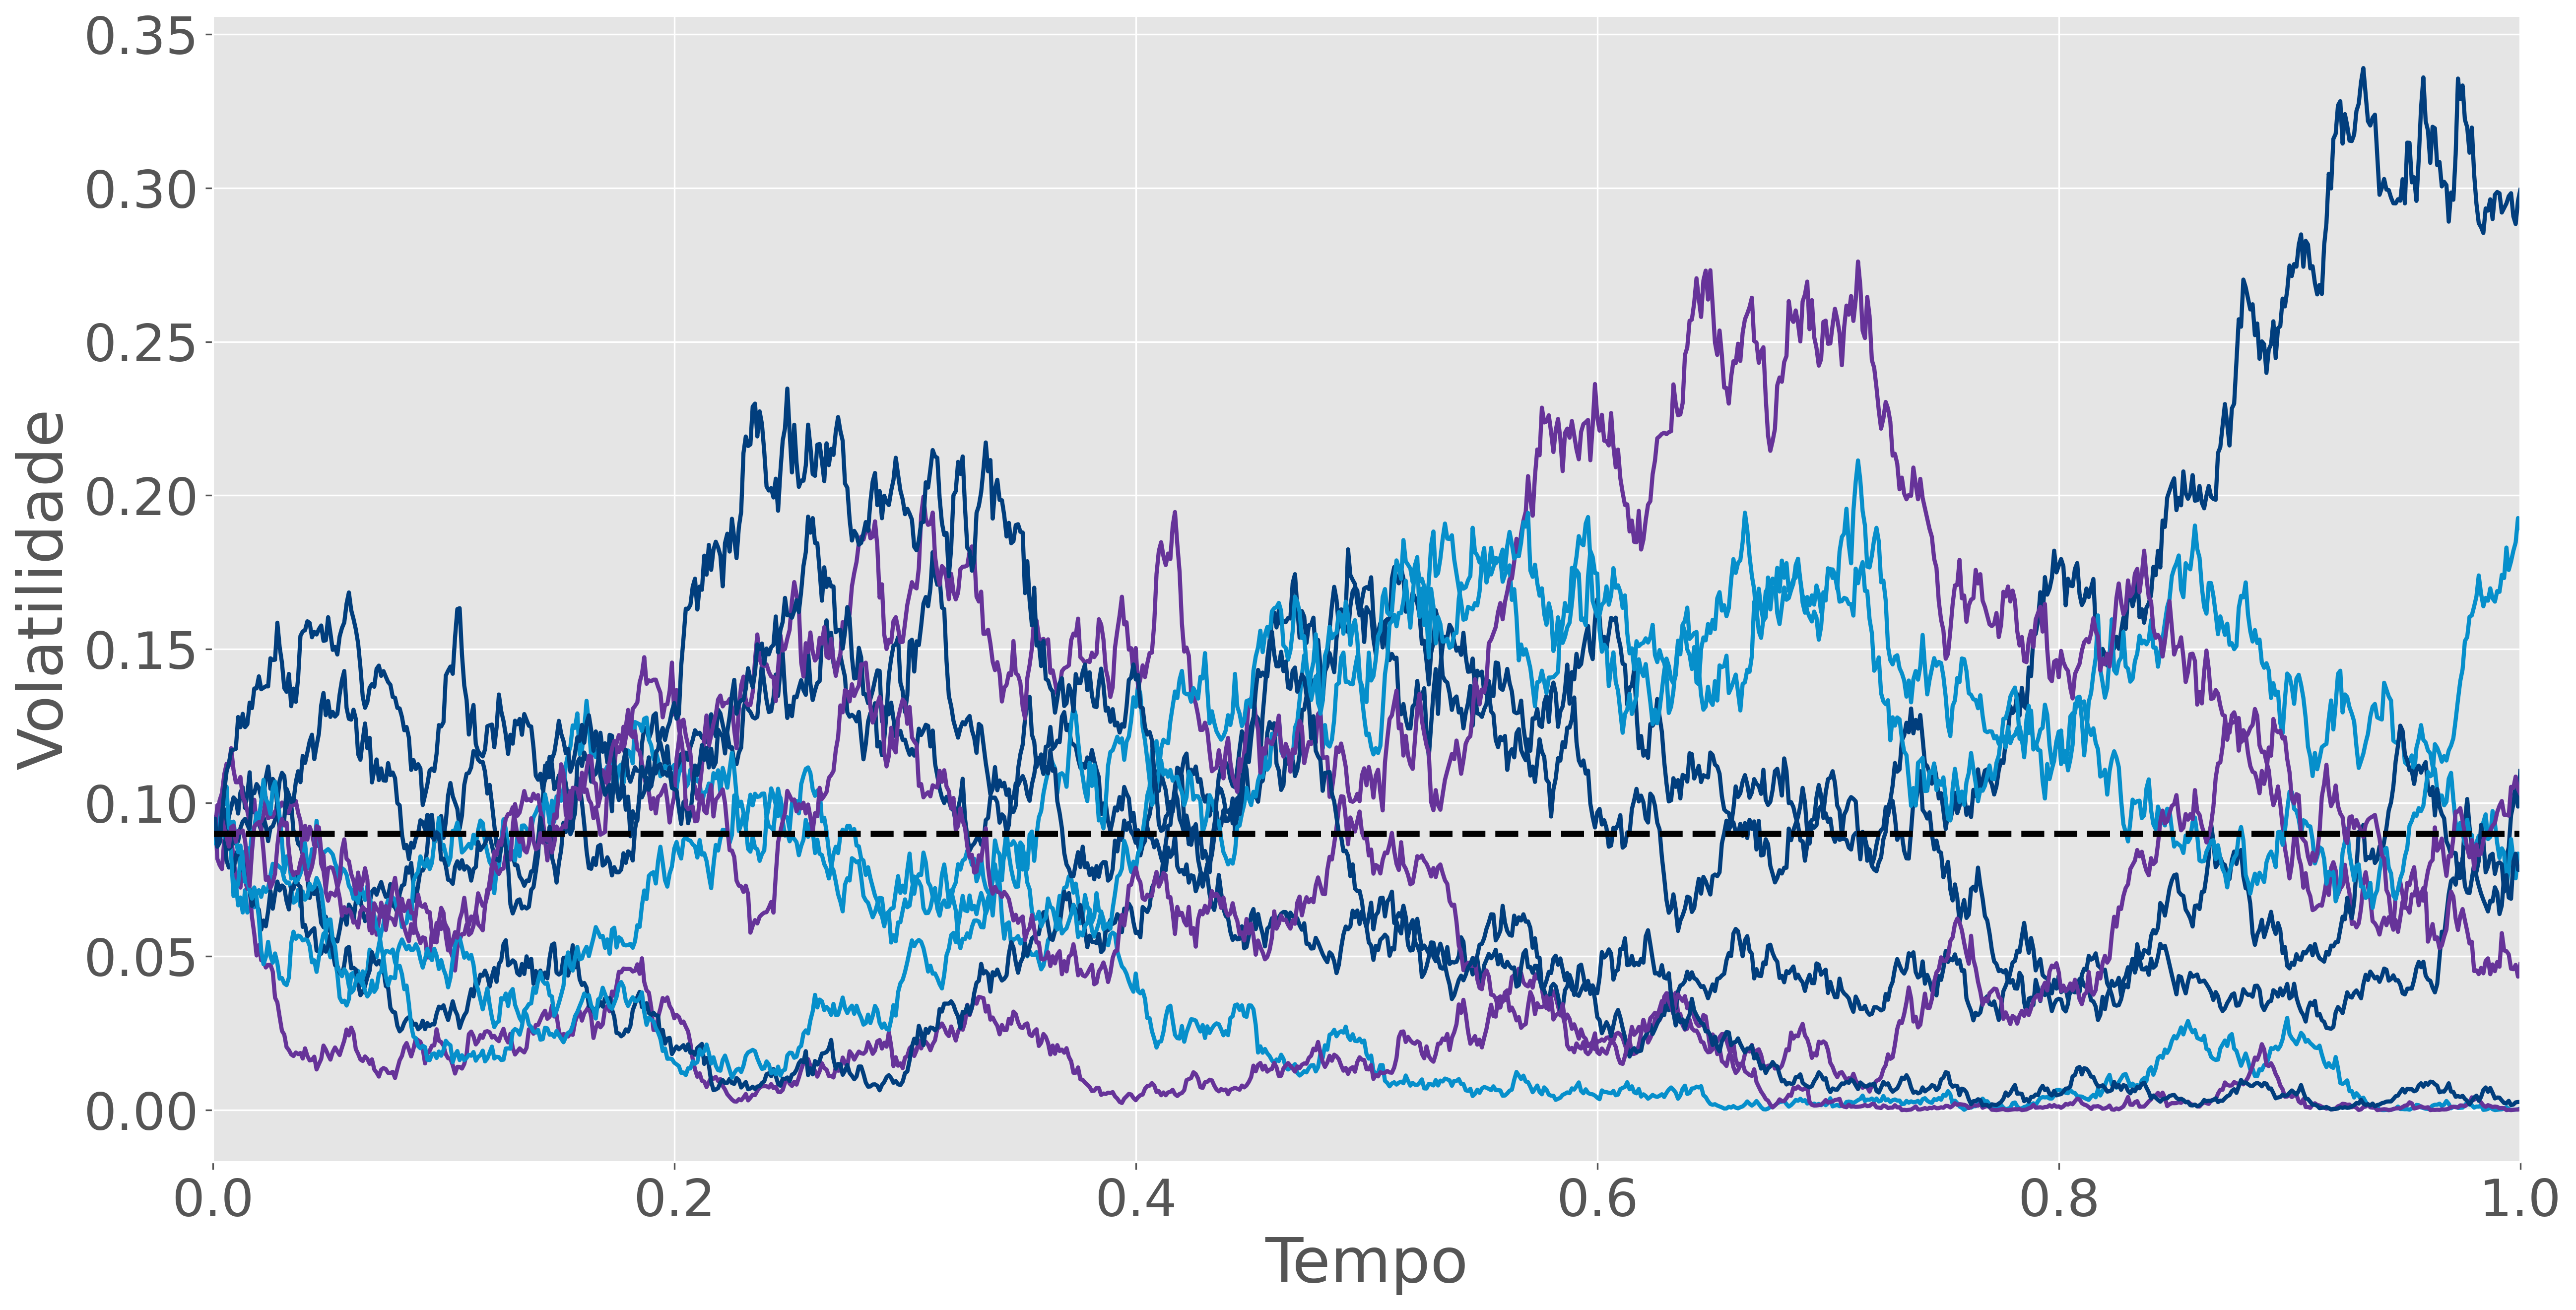

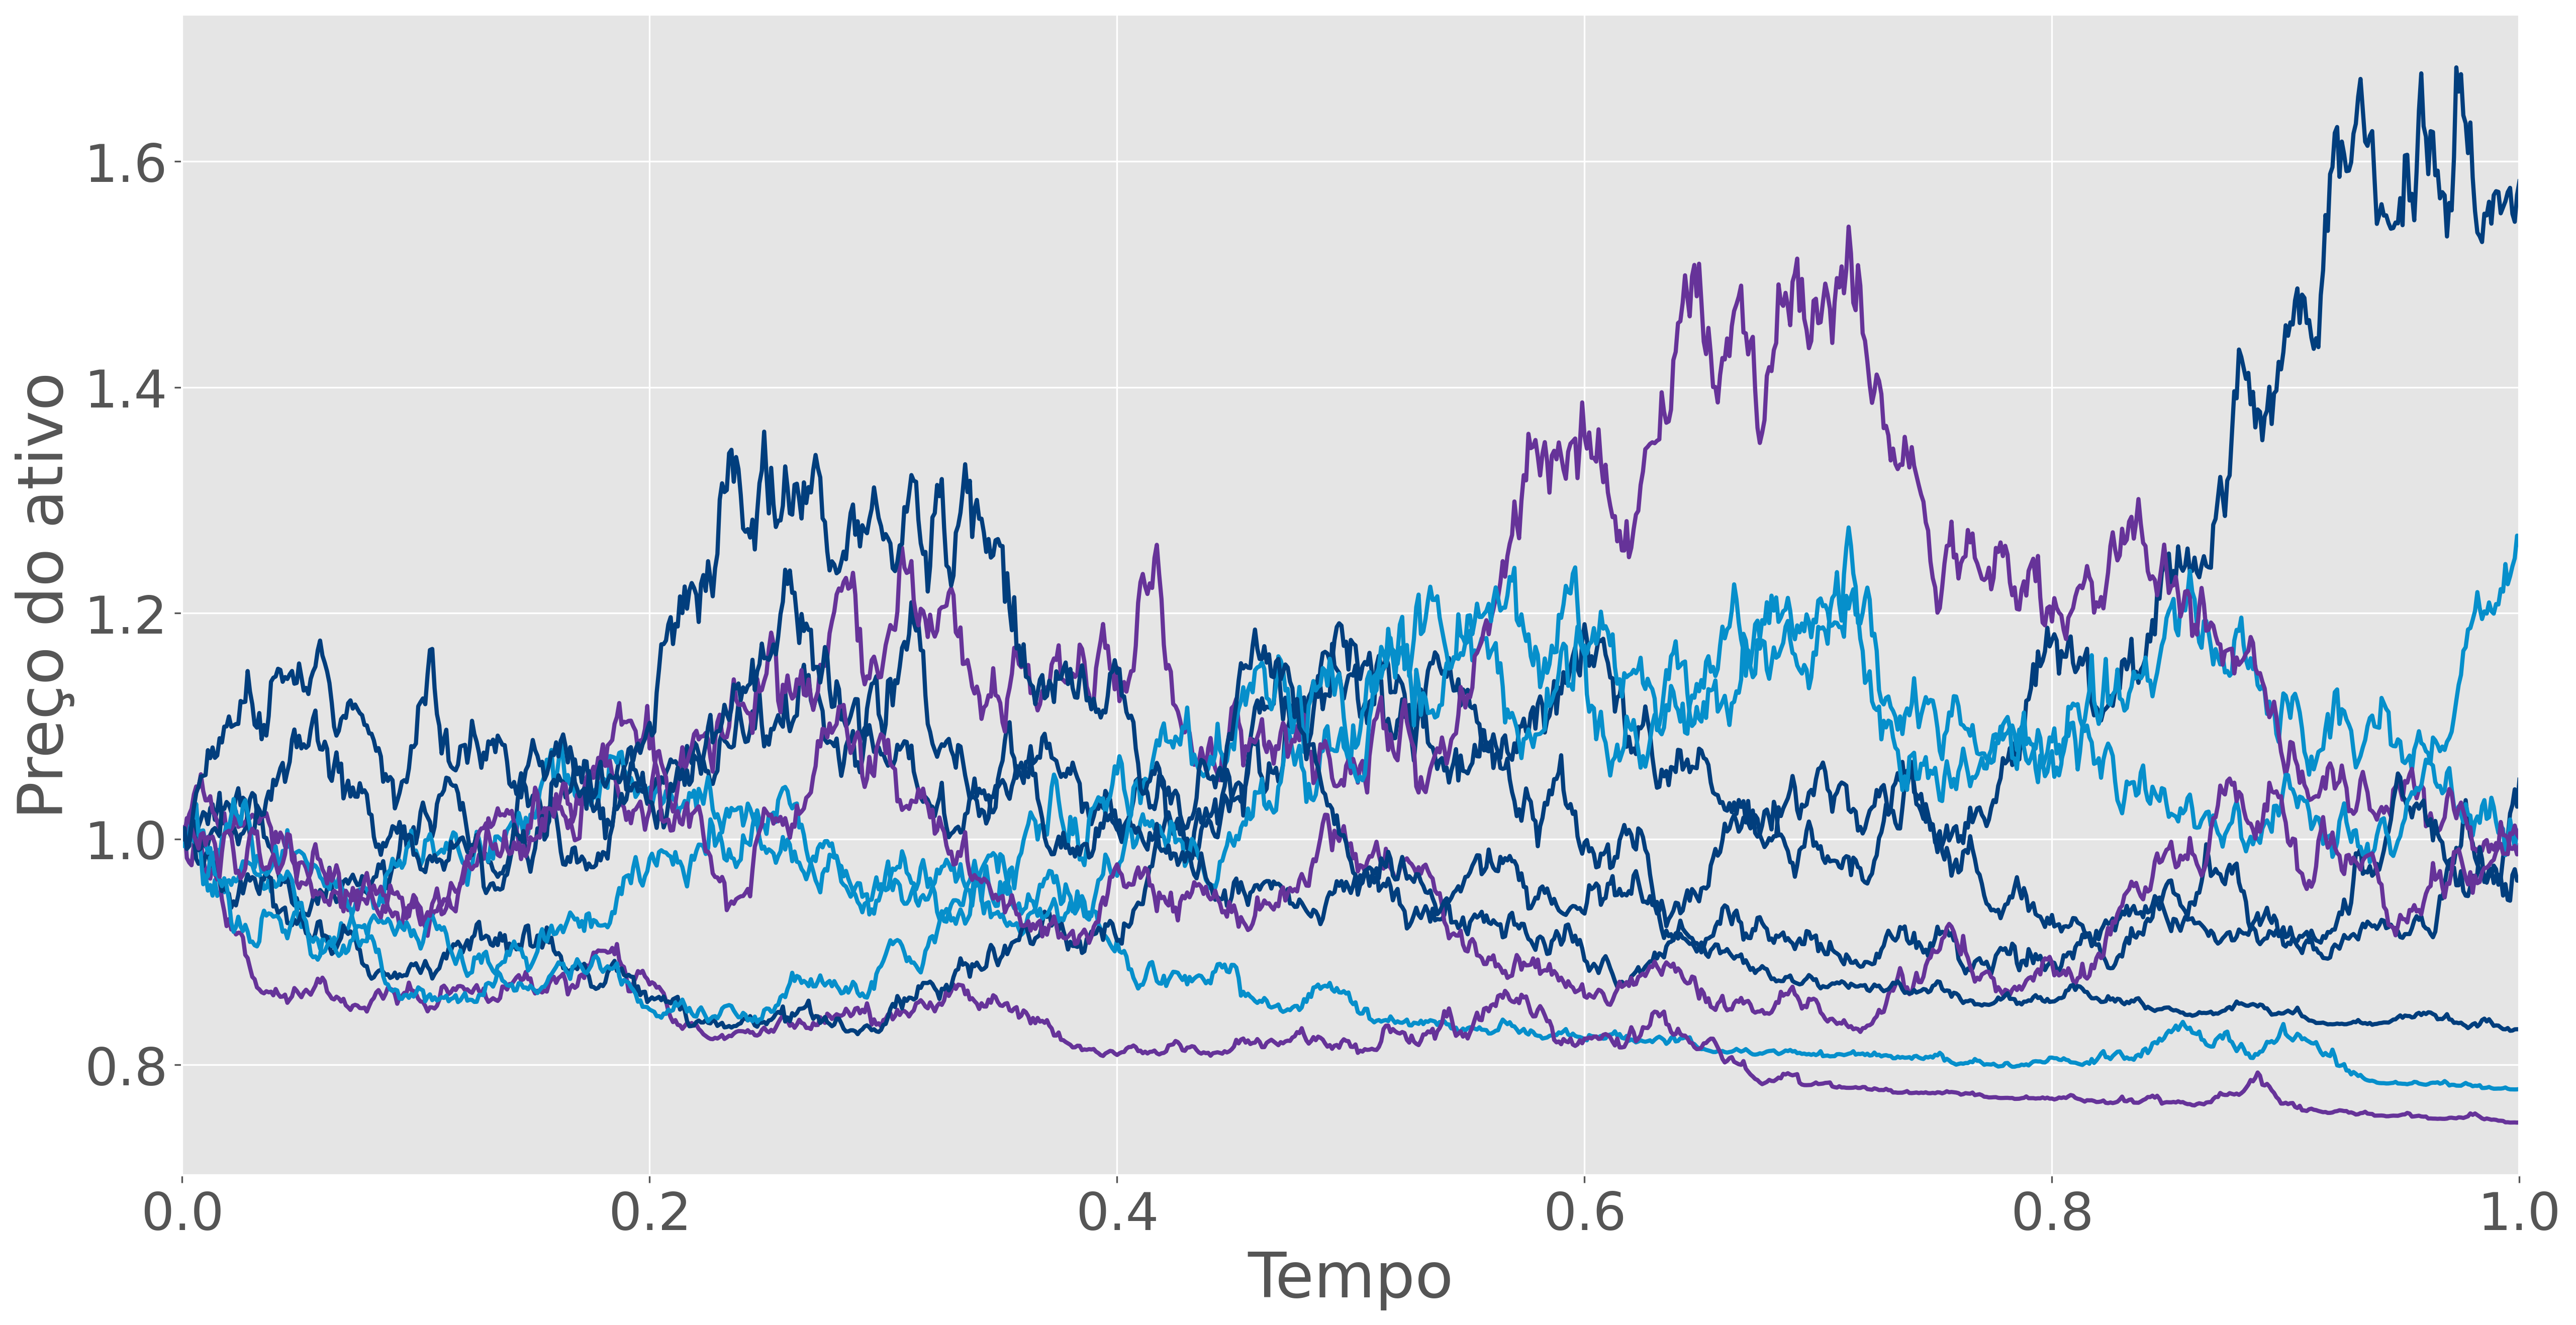

In [9]:
N = 1000 # discretização do tempo
M = 10 # número de simulações
time = np.linspace(0, T, N+1) # time vector
dt = time[1] - time[0]

S, V = SimulateHeston(S0, r, params, dt, N, M)

colors = [color_dark_blue, color_light_blue, purple] * int((M/3 + 1))

plt.figure()
for i in range(M):
    plt.plot(time, V[:,i], linewidth=2, color=colors[i])
plt.axhline(params['m'], color='k', linestyle='dashed', linewidth=3)
plt.xlim(0,T)
plt.xlabel('Tempo')
plt.ylabel('Volatilidade')

plt.figure()
for i in range(M):
    plt.plot(time, S[:,i], linewidth=2, color=colors[i])
plt.xlim(0,T)
plt.xlabel('Tempo')
plt.ylabel('Preço do ativo')

Estatística=0.949, p-valor=0.000
Amostra não parece Gaussiana (H0 é rejeitada)


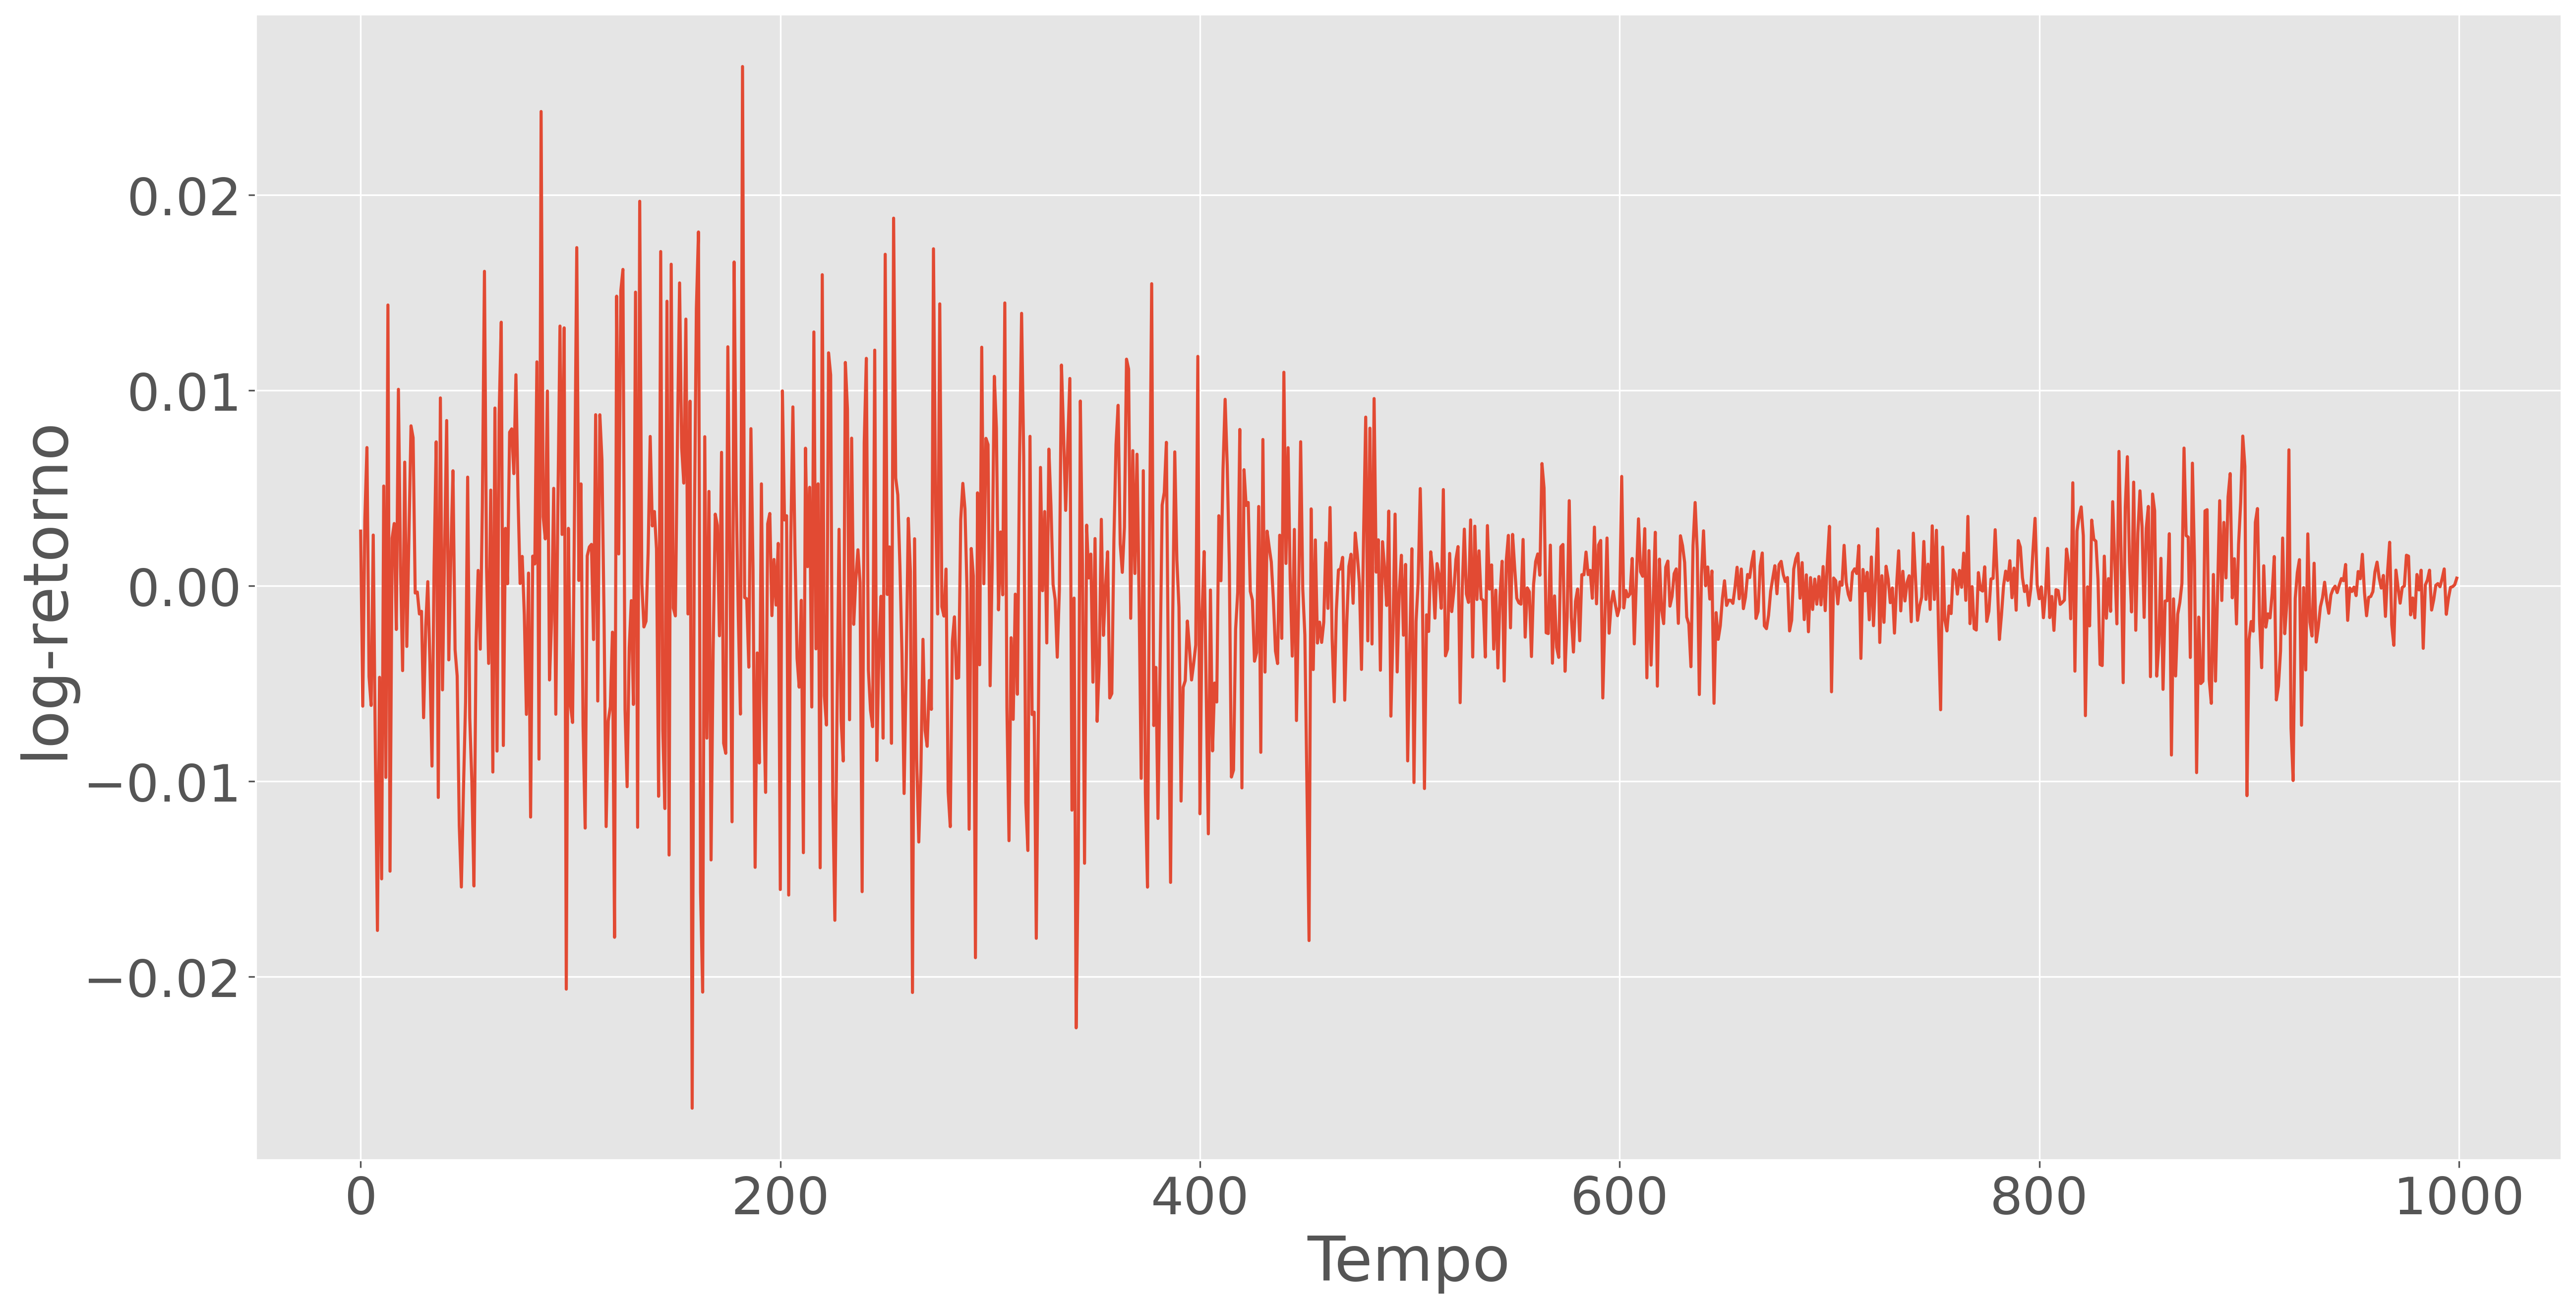

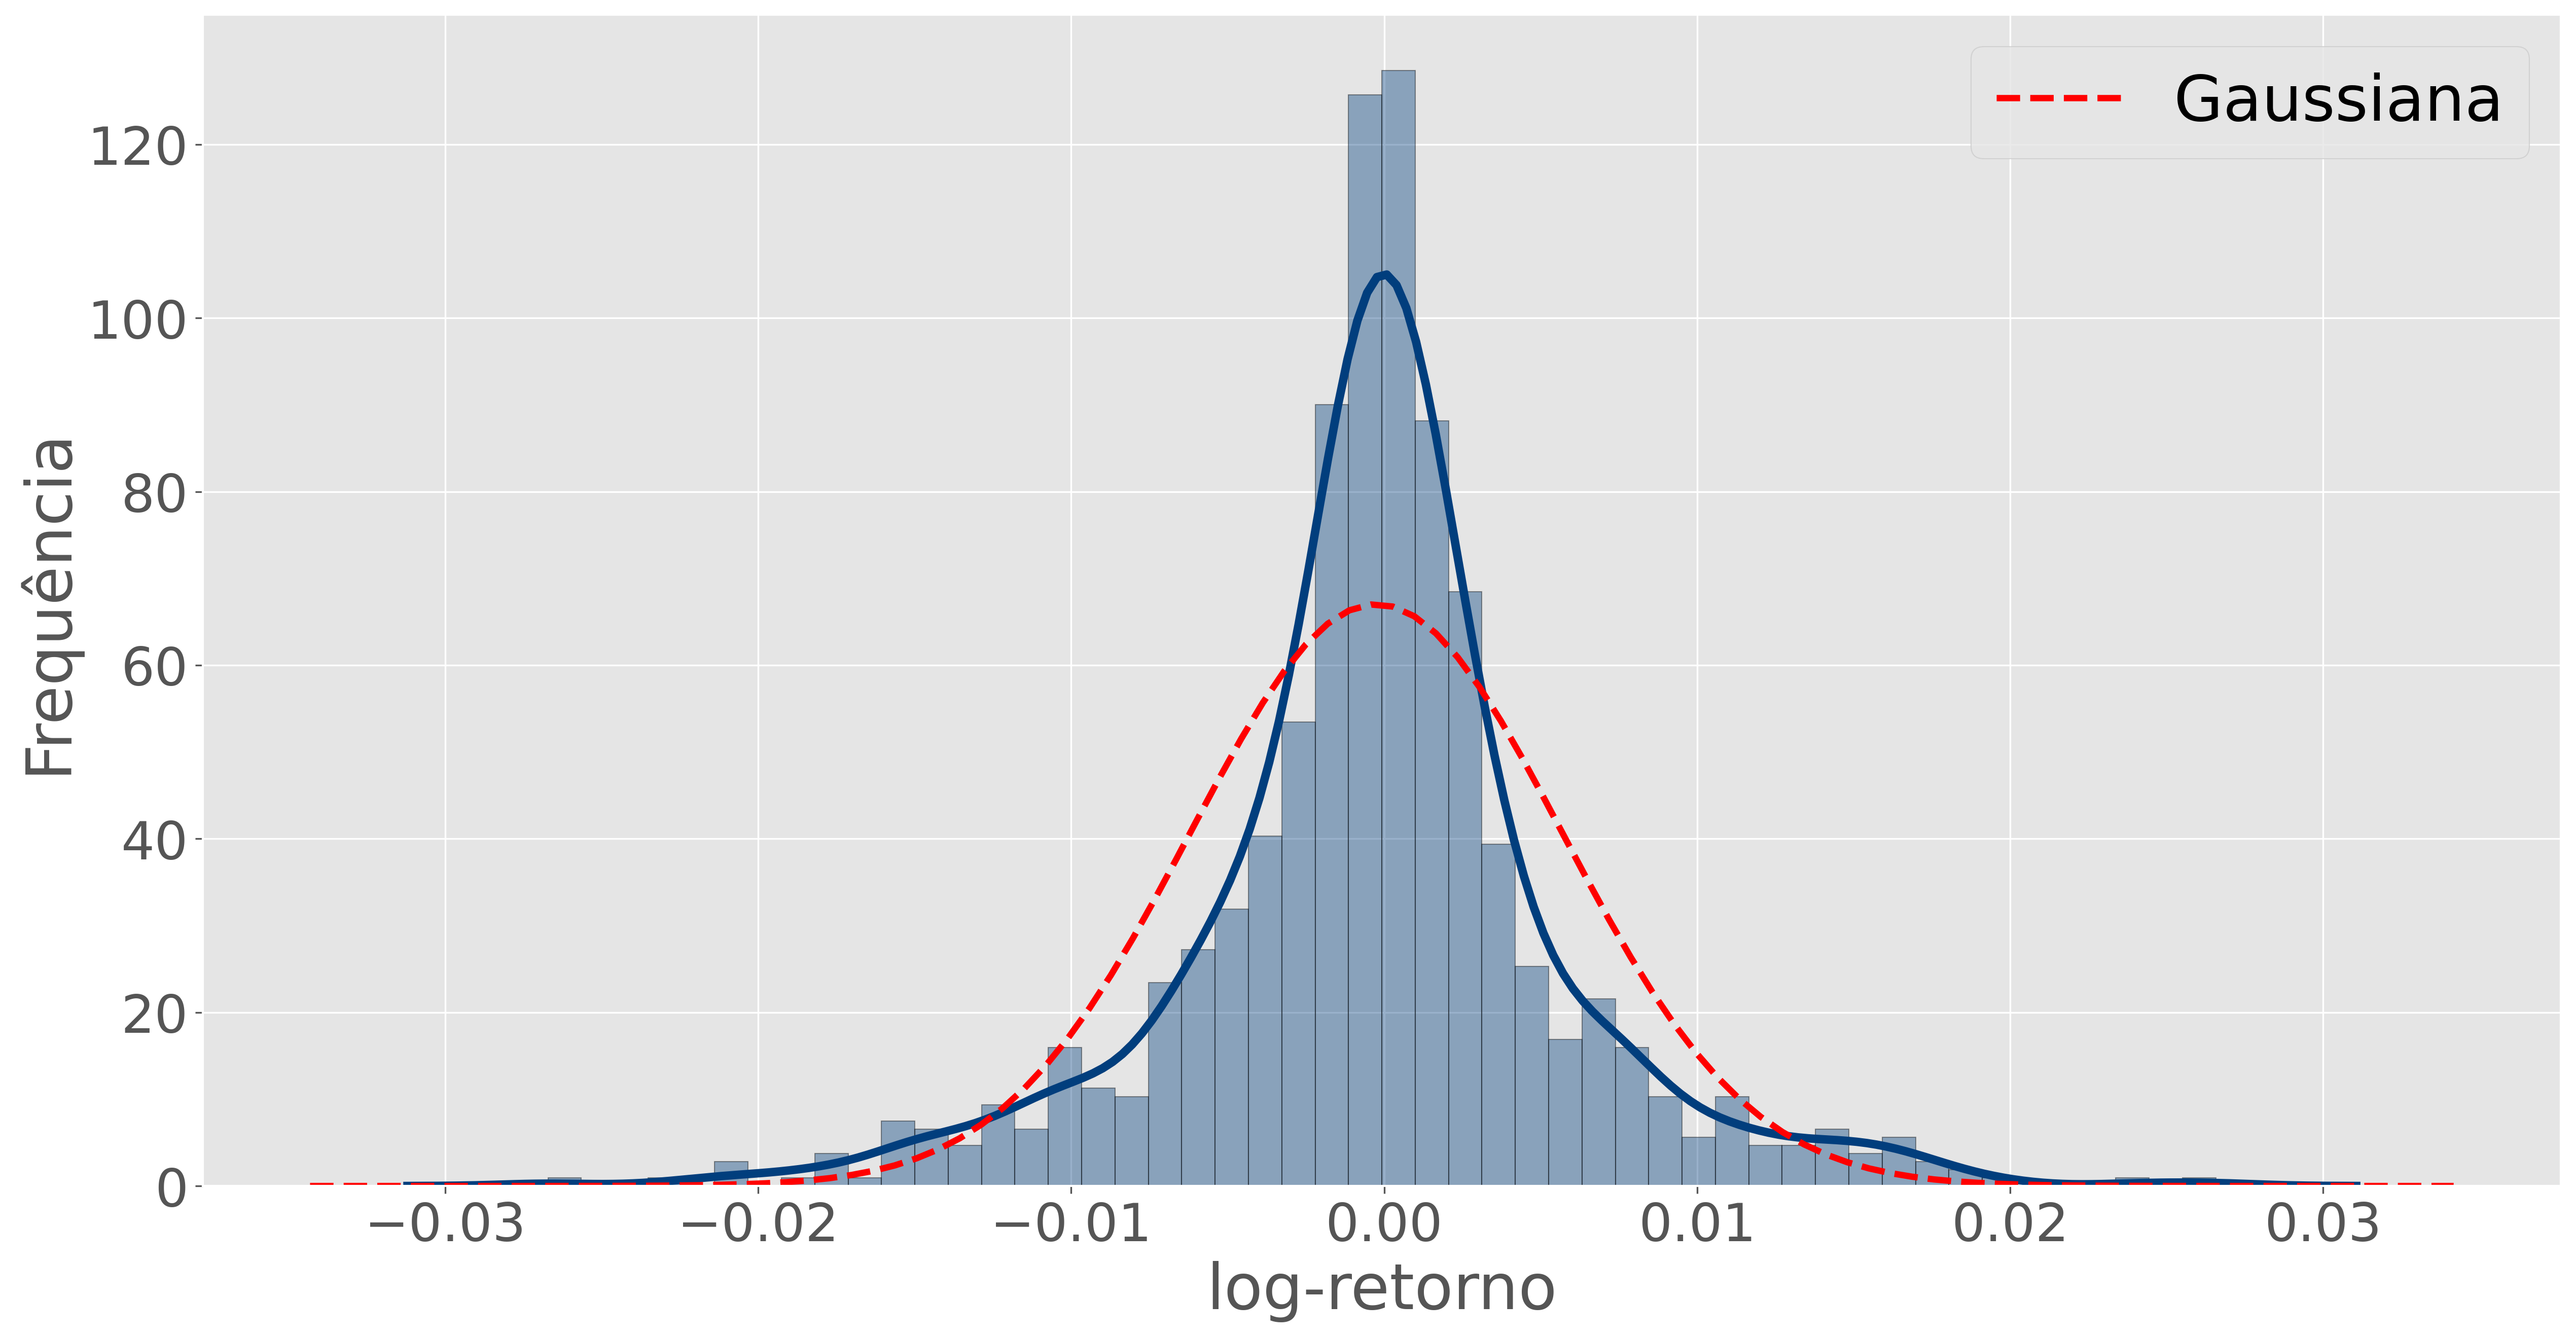

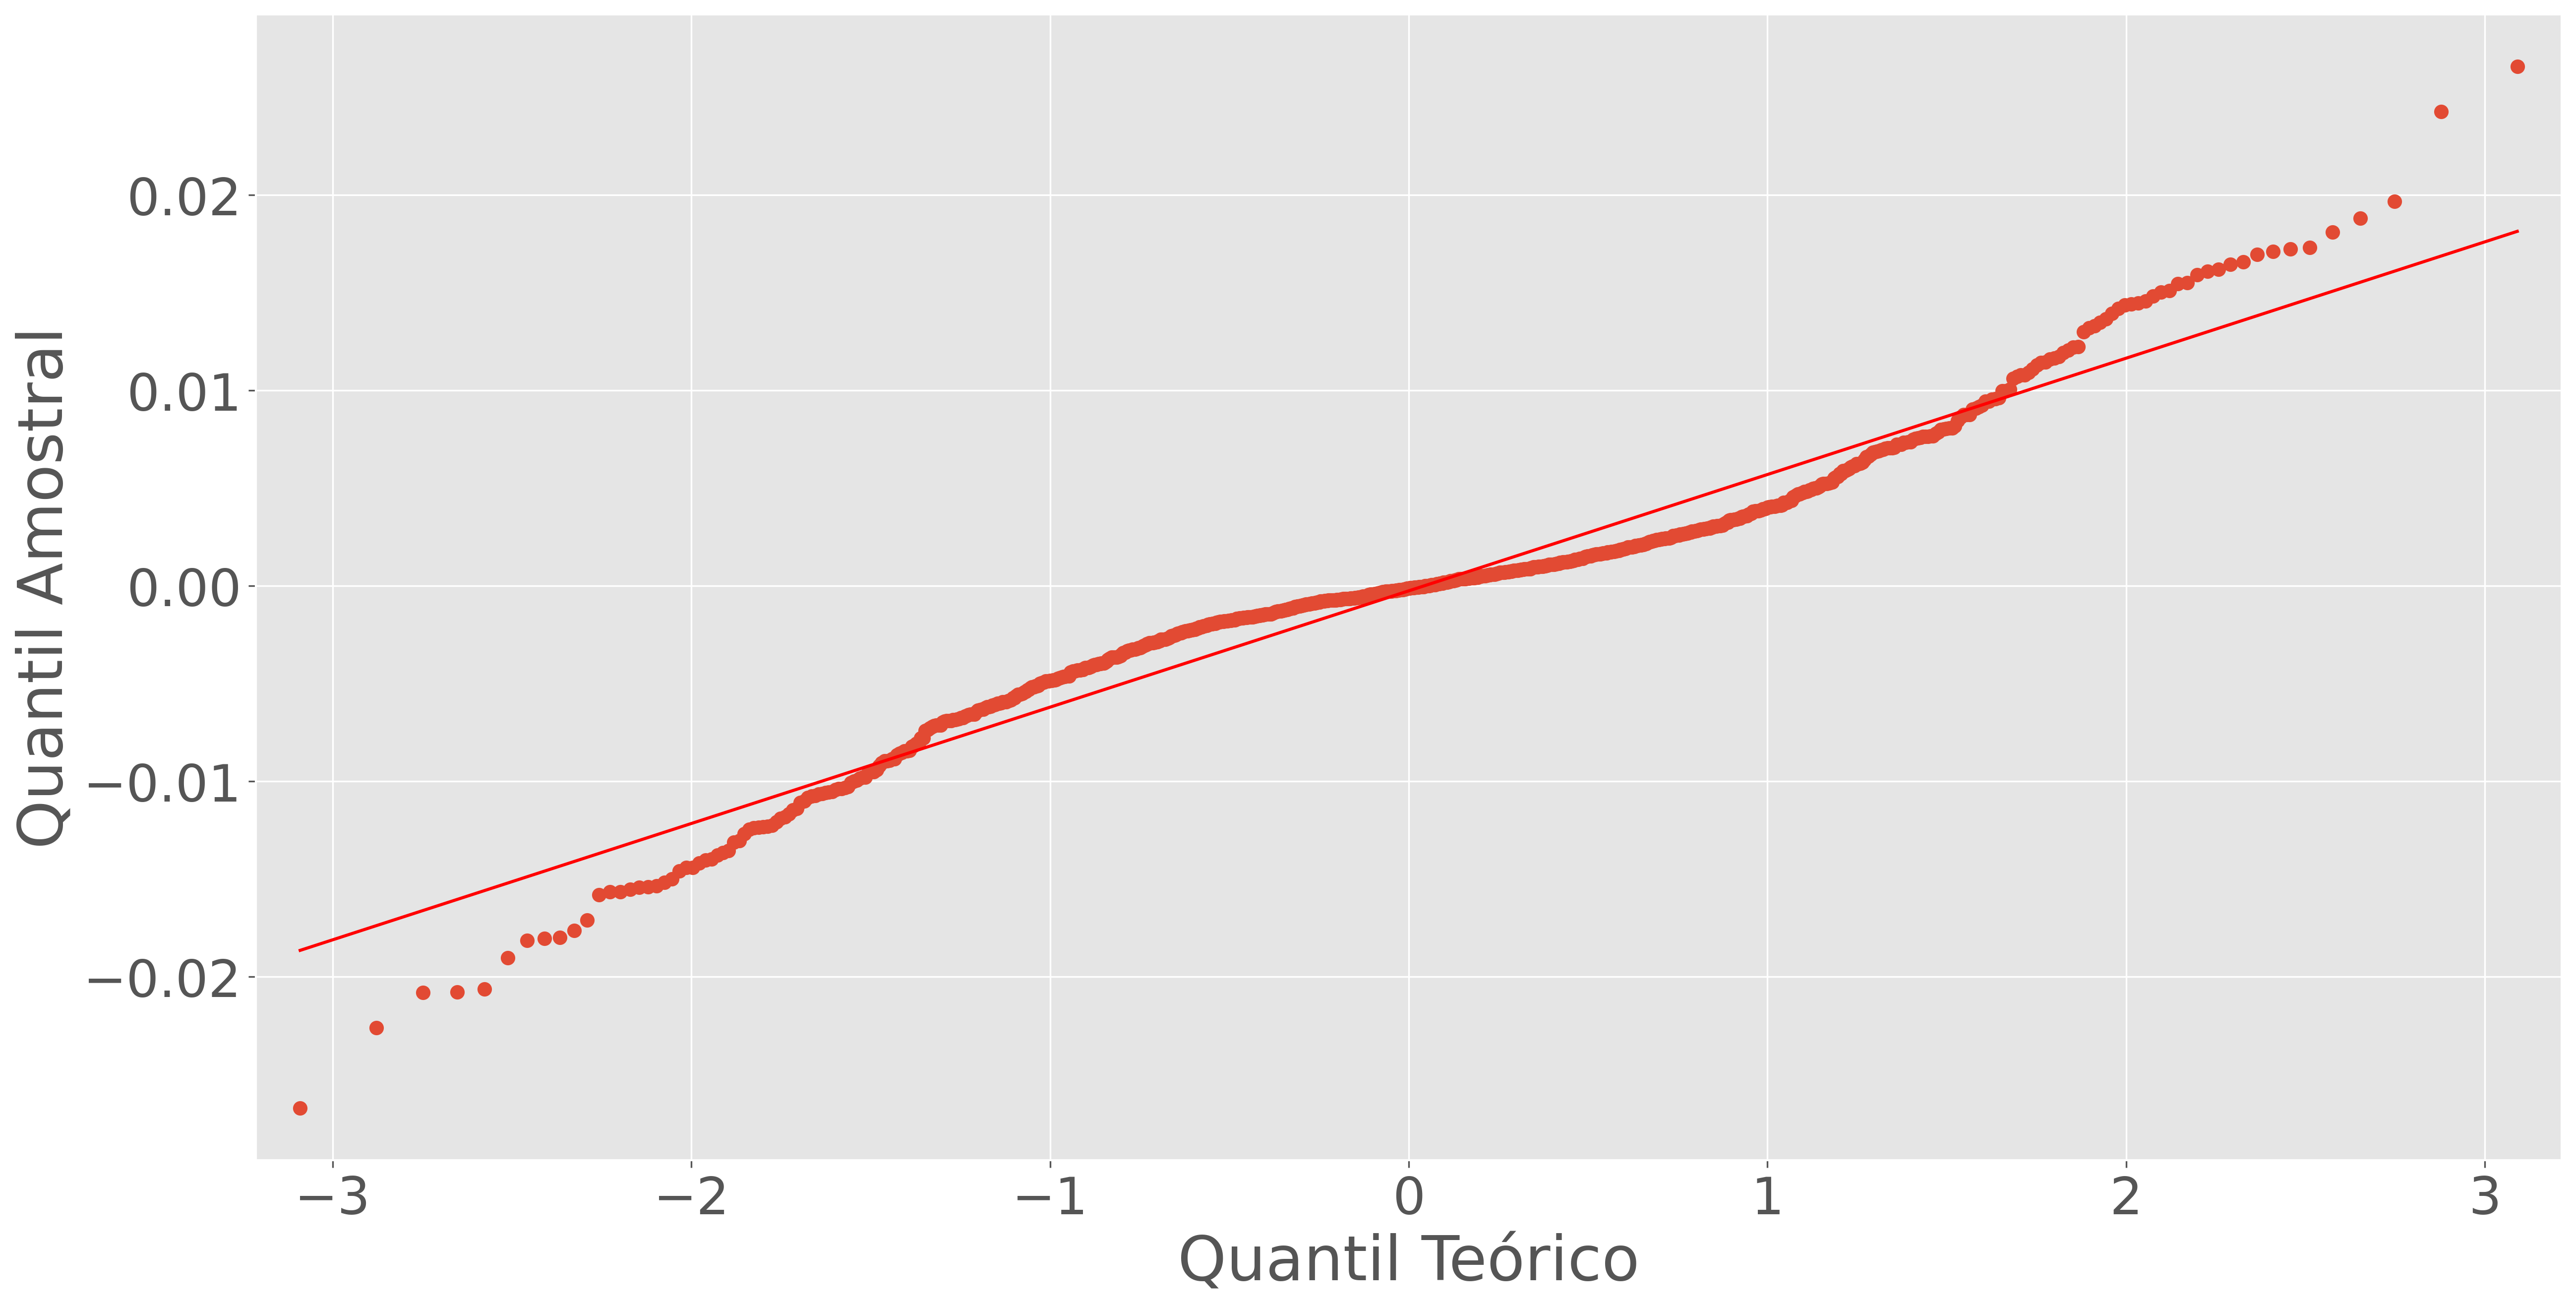

In [10]:
log_return = np.diff(np.log(S[:,1]), axis=0)

# plot o log-retorno
plt.figure()
plt.plot(log_return)
plt.xlabel('Tempo')
plt.ylabel('log-retorno')

# plot o histograma, a estimativa de kernel da densidade e a densidade Gaussiana com média e variância do log-retorno
plt.figure()
sns.distplot(log_return, hist=True, kde=True, 
         bins=50, color = color_dark_blue, 
         hist_kws={'edgecolor':'black'},
         kde_kws={'linewidth': 4})
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(log_return), np.std(log_return))
plt.plot(x, p, color='r', linestyle='dashed', linewidth=3, label='Gaussiana')
plt.xlabel('log-retorno')
plt.ylabel('Frequência')
plt.legend()

# qq-plot dos log-retornos
fig = plt.figure()
ax = fig.add_subplot(111)
qqplot(log_return, line='s', ax=ax, c=color_dark_blue)
plt.xlabel('Quantil Teórico')
plt.ylabel('Quantil Amostral')

# Teste de Shapiro-Wilk para normalidade https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test
stat, p = shapiro(log_return) 
print('Estatística=%.3f, p-valor=%.3f' % (stat, p))
if p > 0.05:
    print('Amostra parece Gaussiana (H0 não é rejeitada)')
else:
    print('Amostra não parece Gaussiana (H0 é rejeitada)')